In [1]:
import pandas as pd
import os
import random

# Define dataset paths
csv_path = "/kaggle/input/all-isic-data-20240629/metadata.csv"
image_dir = "/kaggle/input/all-isic-data-20240629/images"  # Adjust if images are stored differently

# Load the metadata CSV file
df = pd.read_csv(csv_path)

# Define the 7 specific skin cancer classes to extract
selected_classes = [
    "melanoma", "nevus", "basal cell carcinoma", 
    "dermatofibroma", "vascular lesion", 
    "pigmented benign keratosis", "actinic keratosis"
]

# Filter the dataset to keep only these classes
filtered_df = df[df["diagnosis"].isin(selected_classes)]

# Print image counts per class
print("Image count per selected class:")
print(filtered_df["diagnosis"].value_counts())

# Set a maximum number of images per class (adjustable)
max_images_per_class =1000 # Change as needed

# Select a limited number of images per class
selected_images = []
for cls in selected_classes:
    class_subset = filtered_df[filtered_df["diagnosis"] == cls]
    
    # Randomly sample images up to `max_images_per_class`
    selected_subset = class_subset.sample(n=min(max_images_per_class, len(class_subset)), random_state=42)
    
    selected_images.append(selected_subset)

# Combine all selected data
final_df = pd.concat(selected_images)

# Shuffle the final dataset
final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Print final dataset info
print(f"\nTotal images selected: {len(final_df)}")
print(final_df.head())

# Save the filtered metadata for later use
output_csv = "/kaggle/working/filtered_metadata.csv"
final_df.to_csv(output_csv, index=False)
print(f"Filtered metadata saved to: {output_csv}")


<ipython-input-1-250de2c026cf>:10: DtypeWarning: Columns (8,13,16,17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


Image count per selected class:
diagnosis
nevus                         32697
melanoma                       7349
basal cell carcinoma           4921
actinic keratosis              1367
pigmented benign keratosis     1339
dermatofibroma                  420
vascular lesion                 348
Name: count, dtype: int64

Total images selected: 5768
        isic_id                                        attribution  \
0  ISIC_0067281                       Hospital Clínic de Barcelona   
1  ISIC_0029793  ViDIR Group, Department of Dermatology, Medica...   
2  ISIC_0024285                                          Anonymous   
3  ISIC_0031457  ViDIR Group, Department of Dermatology, Medica...   
4  ISIC_0028931  ViDIR Group, Department of Dermatology, Medica...   

  copyright_license  acquisition_day  age_approx anatom_site_general  \
0          CC-BY-NC              NaN        55.0      anterior torso   
1          CC-BY-NC              NaN        70.0                 NaN   
2             

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


diagnosis
basal cell carcinoma          1000
pigmented benign keratosis    1000
nevus                         1000
melanoma                      1000
actinic keratosis             1000
dermatofibroma                 420
vascular lesion                348
Name: count, dtype: int64


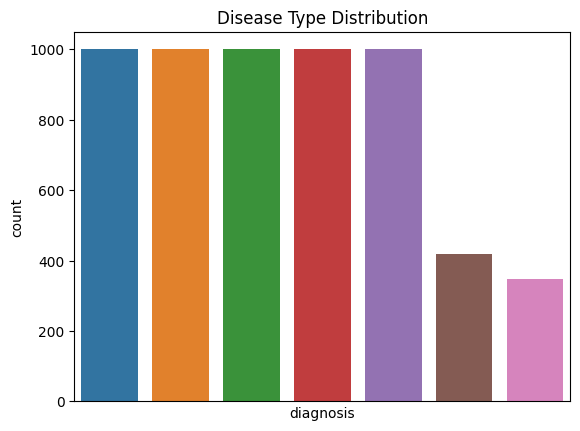

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
csv_path = "/kaggle/working/filtered_metadata.csv"

df = pd.read_csv(csv_path)
print(df['diagnosis'].value_counts())
order = df['diagnosis'].value_counts().index
plt.show()
sns.countplot(x='diagnosis', data=df, order=order)
plt.title('Disease Type Distribution')

# Hide x-axis labels (alternative 1)
plt.xticks([])  # Set empty list for x-axis ticks

plt.show()

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,DepthwiseConv2D,GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
BASE_PATH = '/kaggle/input/all-isic-data-20240629'
IMG_HEIGHT, IMG_WIDTH = 224, 224

In [5]:
metadata_path = os.path.join(BASE_PATH, '/kaggle/working/filtered_metadata.csv')

In [6]:
import os

# Define the base path where images are stored
BASE_PATH = "/kaggle/input/all-isic-data-20240629/images"  # Update this path if needed

def abs_path(x):
    """Returns the absolute path of an image if it exists in the folder."""
    image_file = x + '.jpg'
    image_path = os.path.join(BASE_PATH, image_file)
    
    if os.path.exists(image_path):
        return image_path
    else:
        return None  # Return None if the image is missing



In [7]:
# Load metadata
metadata = pd.read_csv('/kaggle/working/filtered_metadata.csv')
metadata['isic_id'] = metadata['isic_id'].apply(abs_path)


(array([[1024.,    0.,    0., ...,    0.,    0.,    0.],
        [1024.,    0.,    0., ...,    0.,    0.,    0.],
        [1024.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [1024.,    0.,    0., ...,    0.,    0.,    0.],
        [1024.,    0.,    0., ...,    0.,    0.,    0.],
        [1024.,    0.,    0., ...,    0.,    0.,    0.]]),
 array([  0.,  22.,  44.,  66.,  88., 110., 132., 154., 176., 198., 220.]),
 <a list of 1024 BarContainer objects>)

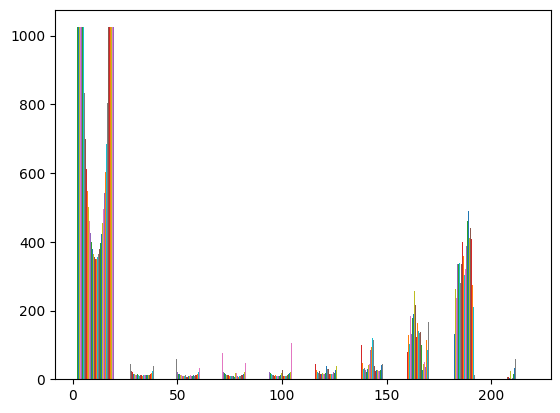

In [8]:
img = cv2.imread(metadata.iloc[0]['isic_id'])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.hist(img)

In [9]:
img = cv2.imread(metadata.iloc[0]['isic_id'])
print(img.shape)

(1024, 1024, 3)


In [10]:
from tqdm import tqdm
IMG_HEIGHT, IMG_WIDTH = 224, 224
def load_and_resize_image(metadata):
    X = []
    y = []
    for idx,row in tqdm(metadata.iterrows()):
        img = cv2.imread(row['isic_id'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = row['diagnosis']
        resized_image = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        resized_image = resized_image/255.0
        X.append(np.array(resized_image))
        y.append(label)
    return np.array(X),np.array(y)

In [11]:
X,y = load_and_resize_image(metadata)

5768it [02:24, 39.79it/s]


Lessions Types & Creating Columns

In [12]:
mel='melanoma'
not_mel='not mel'
metadata['is_mel'] = metadata['diagnosis'].apply(lambda x: mel if x == 'melanoma' else not_mel)

In [13]:
bkl='pigmented benign keratosis'
not_bkl='not bkl'
metadata['is_bkl'] = metadata['diagnosis'].apply(lambda x: bkl if x == 'pigmented benign keratosis' else not_bkl)

In [14]:
bcc='basal cell carcinoma'
not_bcc='not bcc'
metadata['is_bcc'] = metadata['diagnosis'].apply(lambda x: bcc if x == 'basal cell carcinoma' else not_bcc)

In [15]:
akiec='aktinic keratosis'
not_akiec='not akiec'
metadata['is_akiec'] = metadata['diagnosis'].apply(lambda x: akiec if x == 'aktinic keratosis' else not_akiec)

In [16]:
nv='nevus'
not_nv='not nv'
metadata['is_nv'] = metadata['diagnosis'].apply(lambda x: nv if x == 'nevus' else not_nv)

In [17]:
vasc='vascular lesion'
not_vasc='not vasc'
metadata['is_vasc'] = metadata['diagnosis'].apply(lambda x: vasc if x == 'vascular lesion' else not_vasc)

In [18]:
df='dermatofibroma'
not_df='not df'
metadata['is_df'] = metadata['diagnosis'].apply(lambda x: df if x == 'dermatofibroma' else not_df)

In [19]:
metadata.columns

Index(['isic_id', 'attribution', 'copyright_license', 'acquisition_day',
       'age_approx', 'anatom_site_general', 'benign_malignant',
       'clin_size_long_diam_mm', 'concomitant_biopsy', 'dermoscopic_type',
       'diagnosis', 'diagnosis_confirm_type', 'family_hx_mm',
       'fitzpatrick_skin_type', 'image_type', 'lesion_id', 'mel_class',
       'mel_mitotic_index', 'mel_thick_mm', 'mel_type', 'mel_ulcer',
       'melanocytic', 'nevus_type', 'patient_id', 'personal_hx_mm', 'pixels_x',
       'pixels_y', 'sex', 'is_mel', 'is_bkl', 'is_bcc', 'is_akiec', 'is_nv',
       'is_vasc', 'is_df'],
      dtype='object')

In [20]:
train_ind, test_ind = train_test_split(np.arange(len(metadata)), test_size=0.3, random_state=42, stratify=y)

In [21]:
test_ind.shape

(1731,)

In [22]:
test_gen, test_cascade = train_test_split(np.arange(len(test_ind)), test_size=0.33, random_state=42, stratify=y[test_ind])


In [23]:
a=metadata[metadata.index.isin(test_ind)].reset_index()

In [24]:
a[a.index.isin(test_gen)]['diagnosis'].value_counts(normalize=True)

diagnosis
melanoma                      0.183779
pigmented benign keratosis    0.180328
basal cell carcinoma          0.169974
nevus                         0.168248
actinic keratosis             0.167386
dermatofibroma                0.066437
vascular lesion               0.063848
Name: proportion, dtype: float64

In [25]:
a[a.index.isin(test_cascade)]['diagnosis'].value_counts(normalize=True)

diagnosis
actinic keratosis             0.185315
nevus                         0.183566
basal cell carcinoma          0.180070
pigmented benign keratosis    0.159091
melanoma                      0.152098
dermatofibroma                0.085664
vascular lesion               0.054196
Name: proportion, dtype: float64

In [26]:
metadata['diagnosis'].value_counts(normalize=True)

diagnosis
basal cell carcinoma          0.173370
pigmented benign keratosis    0.173370
nevus                         0.173370
melanoma                      0.173370
actinic keratosis             0.173370
dermatofibroma                0.072816
vascular lesion               0.060333
Name: proportion, dtype: float64

In [27]:
BATCH_SiZE = 128

train_datagen = ImageDataGenerator(validation_split=0.1, rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)
    
train_generator = train_datagen.flow_from_dataframe(
    dataframe = metadata[metadata.index.isin(train_ind)],
    #     directory = None,
    x_col = 'isic_id',
    y_col = 'is_nv',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical',
    batch_size = BATCH_SiZE,
    #     shuffle = True,
    subset = 'training',
    )

test_generator = test_datagen.flow_from_dataframe(
    dataframe = metadata[metadata.index.isin(test_ind[test_gen])],
#     directory = images_dir,
    x_col = 'isic_id',
    y_col = 'is_nv',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical',
    batch_size = BATCH_SiZE,
    shuffle = False,
)

Found 3634 validated image filenames belonging to 2 classes.
Found 1159 validated image filenames belonging to 2 classes.


Nevus

In [28]:
# Define the CNN model
model1 = Sequential()

# Add convolutional layers
model1.add(Conv2D(32, (11, 11), activation='relu', input_shape=(224, 224, 3)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(4, 4)))

model1.add(Conv2D(64, (7, 7), activation='tanh'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(128, (5, 5), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(128, (3, 3), activation='tanh'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output
model1.add(Flatten())

# Add fully connected layers
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))  # Dropout for regularization

model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.3))

model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.2))

# Output layer (number of classes for HAM10000 dataset)
model1.add(Dense(2, activation='softmax'))

model1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 214, 214, 32)        │          11,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 53, 53, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 47, 47, 64)          │         100,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 19, 19, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 622,562 (2.37 MB)

 Trainable params: 622,562 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
from keras.optimizers import Adam
MAX_EPOCH=50
# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.0001)
# Compile the model with the correct optimizer and loss
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save the best model
model_checkpoint = ModelCheckpoint('binary_cascading_nv.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the model using batch processing with fit_generator
history = model1.fit(train_generator, validation_data=test_generator, 
                    epochs=MAX_EPOCH, 
#                     steps_per_epoch=len(X_train) // 32,
#                     validation_steps=len(X_val) // 32,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7042 - loss: 0.5902 - val_accuracy: 0.8266 - val_loss: 0.4654
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.8166 - loss: 0.4917 - val_accuracy: 0.8266 - val_loss: 0.4567
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.8221 - loss: 0.4829 - val_accuracy: 0.8266 - val_loss: 0.4450
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.8079 - loss: 0.4917 - val_accuracy: 0.8266 - val_loss: 0.4368
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.8412 - loss: 0.4304 - val_accuracy: 0.8266 - val_loss: 0.4312
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.8336 - loss: 0.4384 - val_accuracy: 0.8266 - val_loss: 0.4214
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.8219 - loss: 0.4247 - val_accuracy: 0.8274 - val_loss: 0.4143
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.8341 - loss: 0.4012 - val_accuracy: 0.8335 - val_loss: 0.3995
Epo

In [30]:
test_loss, test_acc = model1.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# Save the trained model
model1.save('binary_cascading_nv.keras')

10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9031 - loss: 0.2658
Test Accuracy: 0.9016393423080444


In [31]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# 1. Predict
y_pred_prob = model1.predict(test_generator)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# 2. True labels
y_true = test_generator.classes

# 3. Get classification report as dictionary
report_dict = classification_report(
    y_true, y_pred_classes, 
    target_names=test_generator.class_indices.keys(), 
    output_dict=True
)

# 4. Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# 5. Format:
def format_value_full(x):
    if isinstance(x, (int, np.integer)):
        return int(x)
    elif isinstance(x, (float, np.floating)):
        return float(x)  # No rounding
    else:
        return x

report_df = report_df.applymap(format_value_full)

print(report_df)

# 6. Optional: Save to Excel
report_df.to_excel('classification_report_full_precision.xlsx', index=True)

10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
              precision    recall  f1-score      support
nevus          0.871795  0.507463  0.641509   201.000000
not nv         0.904990  0.984342  0.943000   958.000000
accuracy       0.901639  0.901639  0.901639     0.901639
macro avg      0.888393  0.745903  0.792255  1159.000000
weighted avg   0.899233  0.901639  0.890714  1159.000000


<ipython-input-31-6cb945e48055>:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  report_df = report_df.applymap(format_value_full)


In [32]:
test_generator.class_indices

{'nevus': 0, 'not nv': 1}

In [33]:
import pandas as pd
from sklearn.metrics import roc_curve

# 1. Get true labels
y_true = test_generator.classes

# 2. Predict PROBABILITIES
y_pred_prob = model1.predict(test_generator)

# 3. Take probability for class 1
y_pred_prob_class1 = y_pred_prob[:, 1]

# 4. Compute FPR, TPR, Thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob_class1)

# 5. Create a DataFrame
roc_data = pd.DataFrame({
    'False Positive Rate (FPR)': fpr,
    'True Positive Rate (TPR)': tpr,
    'Thresholds': thresholds
})

# 6. Save to Excel
roc_data.to_excel('roc_data_nv.xlsx', index=False)

print("ROC data saved successfully to 'roc_data.xlsx'.")

10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
ROC data saved successfully to 'roc_data.xlsx'.


Number of test samples: 1159
Batch size: 128
Steps: 10
Class indices: {'nevus': 0, 'not nv': 1}
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
Shape of predictions: (1159, 2)
Unique y_true values: [0 1]
y_true type: <class 'numpy.int64'>
Sample y_true (first 10): [1 0 1 1 1 1 1 1 1 1]
Sample y_pred (first 10): [1 0 1 1 1 1 1 1 1 1]
Length of y_true: 1159
Length of y_pred: 1159
y_pred type: <class 'numpy.int64'>
Accuracy from confusion matrix: 90.16%


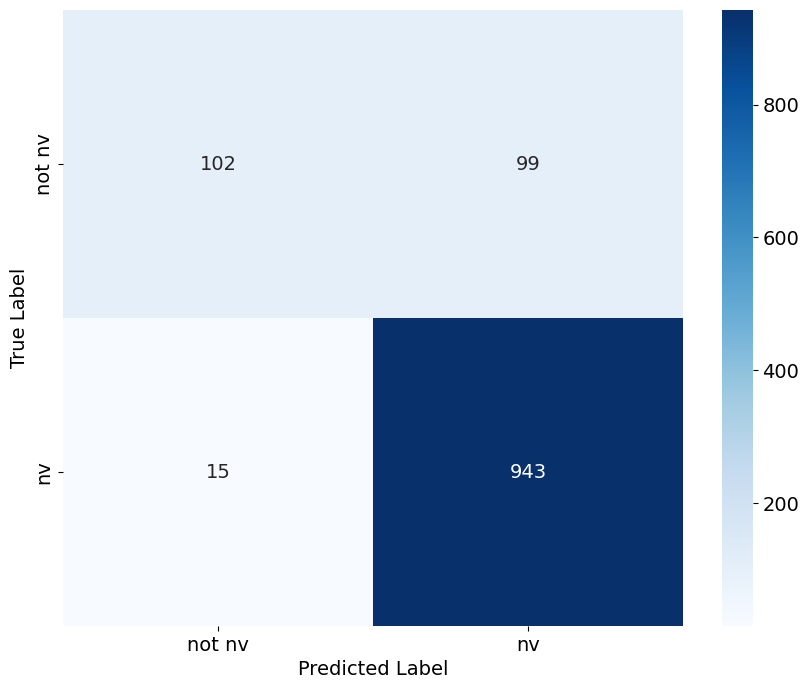

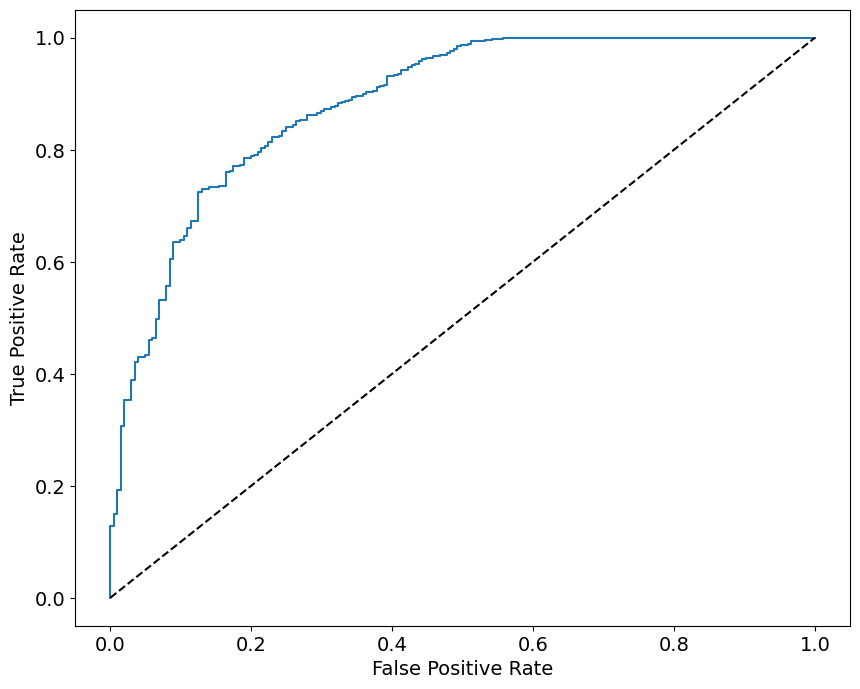

              precision    recall  f1-score   support

      not nv       0.87      0.51      0.64       201
          nv       0.90      0.98      0.94       958

    accuracy                           0.90      1159
   macro avg       0.89      0.75      0.79      1159
weighted avg       0.90      0.90      0.89      1159



In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report
import os

# Ensure output directory exists
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

# Reset test_generator to ensure it starts from the first sample
test_generator.reset()

# Get the number of samples and batch size
num_samples = test_generator.n  # Total number of samples (2013)
batch_size = test_generator.batch_size  # 128
steps = int(np.ceil(num_samples / batch_size))  # 16

# Debug: Print number of samples, batch size, steps, and class indices
print(f"Number of test samples: {num_samples}")
print(f"Batch size: {batch_size}")
print(f"Steps: {steps}")
print(f"Class indices: {test_generator.class_indices}")

# Predict probabilities using model2
predictions = model1.predict(test_generator, steps=steps)

# Debug: Print shape of predictions
print(f"Shape of predictions: {predictions.shape}")

# Handle model output
if predictions.shape[1] == 2:
    y_pred_prob = predictions[:, 1]  # Softmax: probability for positive class ("nv")
elif predictions.shape[1] == 1:
    y_pred_prob = predictions.ravel()  # Sigmoid output
else:
    raise ValueError(f"Unexpected model output shape: {predictions.shape}")

y_pred = (y_pred_prob > 0.5).astype(int)

# Get true labels from test_generator and convert to NumPy array
y_true = np.array(test_generator.classes, dtype=np.int64)

# Debug: Print unique values, types, and sample labels
print(f"Unique y_true values: {np.unique(y_true)}")
print(f"y_true type: {type(y_true[0])}")
print(f"Sample y_true (first 10): {y_true[:10]}")
print(f"Sample y_pred (first 10): {y_pred[:10]}")
print(f"Length of y_true: {len(y_true)}")
print(f"Length of y_pred: {len(y_pred)}")
print(f"y_pred type: {type(y_pred[0])}")

# Ensure y_true and y_pred have the same length and type
assert len(y_true) == len(y_pred), f"Mismatch between y_true ({len(y_true)}) and y_pred ({len(y_pred)}) lengths"
assert isinstance(y_true[0], type(y_pred[0])), f"Type mismatch: y_true ({type(y_true[0])}), y_pred ({type(y_pred[0])})"

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['not nv', 'nv']

# Compute accuracy from confusion matrix
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"Accuracy from confusion matrix: {accuracy:.2%}")

# Plot and Save Confusion Matrix as Heatmap using Seaborn
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 14})
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# plt.title('Confusion Matrix Heatmap (Model1)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(os.path.join(output_dir, 'confusion_matrix_heatmap_model1.png'), dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# # Plot and Save Confusion Matrix using ConfusionMatrixDisplay
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
# disp.plot(cmap='Blues')
# plt.title('Confusion Matrix (Model1)')
# plt.savefig(os.path.join(output_dir, 'confusion_matrix_display_model2.png'), dpi=300, bbox_inches='tight')
# plt.show()
# plt.close()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 14})
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC Curve (Model1)')
# plt.legend(loc='lower right')
plt.savefig(os.path.join(output_dir, 'roc_curve_model1.png'), dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# Save Classification Report to a text file
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)
with open(os.path.join(output_dir, 'classification_report_model1.txt'), 'w') as f:
    f.write(report)

Melanoma

In [35]:
nv_indices = metadata[metadata['diagnosis'] == 'nevus'].index

In [36]:
train_ind_filtered=np.setdiff1d(train_ind,nv_indices)
test_ind_filtered=np.setdiff1d(test_ind[test_gen],nv_indices)

In [37]:
BATCH_SiZE = 32

train_datagen = ImageDataGenerator(validation_split=0.1, rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)
    
train_generator_mel = train_datagen.flow_from_dataframe(
    dataframe = metadata[metadata.index.isin(train_ind_filtered)],
    #     directory = None,
    x_col = 'isic_id',
    y_col = 'is_mel',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical',
    batch_size = BATCH_SiZE,
    #     shuffle = True,
    subset = 'training',
    )

test_generator_mel = test_datagen.flow_from_dataframe(
    dataframe = metadata[metadata.index.isin(test_ind_filtered)],
#     directory = images_dir,
    x_col = 'isic_id',
    y_col = 'is_mel',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical',
    batch_size = BATCH_SiZE,
    shuffle = False,
)

Found 3004 validated image filenames belonging to 2 classes.
Found 958 validated image filenames belonging to 2 classes.


In [38]:
# Define the CNN model
model2 = Sequential()

# Add convolutional layers
model2.add(Conv2D(32, (11, 11), activation='relu', input_shape=(224, 224, 3)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(4, 4)))

model2.add(Conv2D(64, (7, 7), activation='tanh'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(128, (5, 5), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(128, (3, 3), activation='tanh'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output
model2.add(Flatten())

# Add fully connected layers
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))  # Dropout for regularization

model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.3))

model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.2))

# Output layer (number of classes for HAM10000 dataset)
model2.add(Dense(2, activation='softmax'))

model2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 214, 214, 32)        │          11,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 53, 53, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 47, 47, 64)          │         100,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 19, 19, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 622,562 (2.37 MB)

 Trainable params: 622,562 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
from keras.optimizers import Adam
MAX_EPOCH=50
# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.0001)
# Compile the model with the correct optimizer and loss
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Save the best model
model_checkpoint = ModelCheckpoint('binary_cascading_mel.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the model using batch processing with fit_generator
history = model2.fit(train_generator_mel, validation_data=test_generator_mel, 
                    epochs=MAX_EPOCH, 
#                     steps_per_epoch=len(X_train) // 32,
#                     validation_steps=len(X_val) // 32,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 65s 587ms/step - accuracy: 0.7580 - loss: 0.5664 - val_accuracy: 0.7923 - val_loss: 0.4739
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 49s 493ms/step - accuracy: 0.8055 - loss: 0.4844 - val_accuracy: 0.8079 - val_loss: 0.4554
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 49s 495ms/step - accuracy: 0.7950 - loss: 0.4884 - val_accuracy: 0.8017 - val_loss: 0.4633
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 50s 502ms/step - accuracy: 0.8082 - loss: 0.4598 - val_accuracy: 0.8152 - val_loss: 0.4339
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 49s 494ms/step - accuracy: 0.8077 - loss: 0.4337 - val_accuracy: 0.8121 - val_loss: 0.4440
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 51s 494ms/step - accuracy: 0.8093 - loss: 0.4427 - val_accuracy: 0.8173 - val_loss: 0.4239
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 49s 486ms/step - accuracy: 0.8234 - loss: 0.4162 - val_accuracy: 0.8173 - val_loss: 0.4271
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 48s 482ms/step - accuracy: 0.8237 - loss: 0.4225 - val_accuracy: 0.823

In [40]:
test_loss, test_acc = model2.evaluate(test_generator_mel)
print(f"Test Accuracy: {test_acc}")

# Save the trained model
model2.save('binary_cascading_mel.keras')

30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 385ms/step - accuracy: 0.8341 - loss: 0.4004
Test Accuracy: 0.8392484188079834


In [45]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# 1. Predict
y_pred_prob = model2.predict(test_generator_mel)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# 2. True labels
y_true = test_generator_mel.classes

# 3. Get classification report as dictionary
report_dict = classification_report(
    y_true, y_pred_classes, 
    target_names=test_generator_mel.class_indices.keys(), 
    output_dict=True
)

# 4. Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# 5. Format:
def format_value_full(x):
    if isinstance(x, (int, np.integer)):
        return int(x)
    elif isinstance(x, (float, np.floating)):
        return float(x)  # No rounding
    else:
        return x

report_df = report_df.applymap(format_value_full)

print(report_df)

# 6. Optional: Save to Excel
report_df.to_excel('classification_report_full_precision_2.xlsx', index=True)

30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 391ms/step
              precision    recall  f1-score     support
melanoma       0.711712  0.393035  0.506410  201.000000
not mel        0.855962  0.957728  0.903990  757.000000
accuracy       0.839248  0.839248  0.839248    0.839248
macro avg      0.783837  0.675381  0.705200  958.000000
weighted avg   0.825697  0.839248  0.820573  958.000000


<ipython-input-45-271da0466cd9>:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  report_df = report_df.applymap(format_value_full)


In [46]:
test_generator_mel.class_indices

{'melanoma': 0, 'not mel': 1}

In [48]:
import pandas as pd
from sklearn.metrics import roc_curve

# 1. Get true labels
y_true = test_generator_mel.classes

# 2. Predict PROBABILITIES
y_pred_prob = model2.predict(test_generator_mel)

# 3. Take probability for class 1
y_pred_prob_class1 = y_pred_prob[:, 0]

# 4. Compute FPR, TPR, Thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob_class1)

# 5. Create a DataFrame
roc_data = pd.DataFrame({
    'False Positive Rate (FPR)': fpr,
    'True Positive Rate (TPR)': tpr,
    'Thresholds': thresholds
})

# 6. Save to Excel
roc_data.to_excel('roc_data_mel.xlsx', index=False)

print("ROC data saved successfully to 'roc_data.xlsx'.")

30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 387ms/step
ROC data saved successfully to 'roc_data.xlsx'.


Number of test samples: 958
Batch size: 32
Steps: 30
Class indices: {'melanoma': 0, 'not mel': 1}
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 397ms/step
Shape of predictions: (958, 2)
Unique y_true values: [0 1]
y_true type: <class 'numpy.int64'>
Sample y_true (first 10): [1 1 1 1 1 1 1 1 0 1]
Sample y_pred (first 10): [1 1 1 1 1 1 1 1 1 1]
Length of y_true: 958
Length of y_pred: 958
y_pred type: <class 'numpy.int64'>
Accuracy from confusion matrix: 83.92%


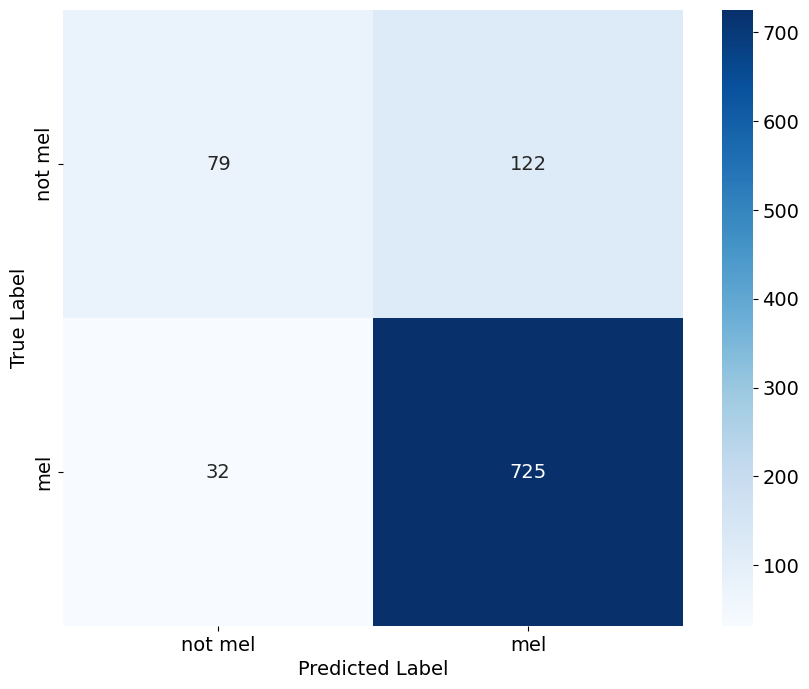

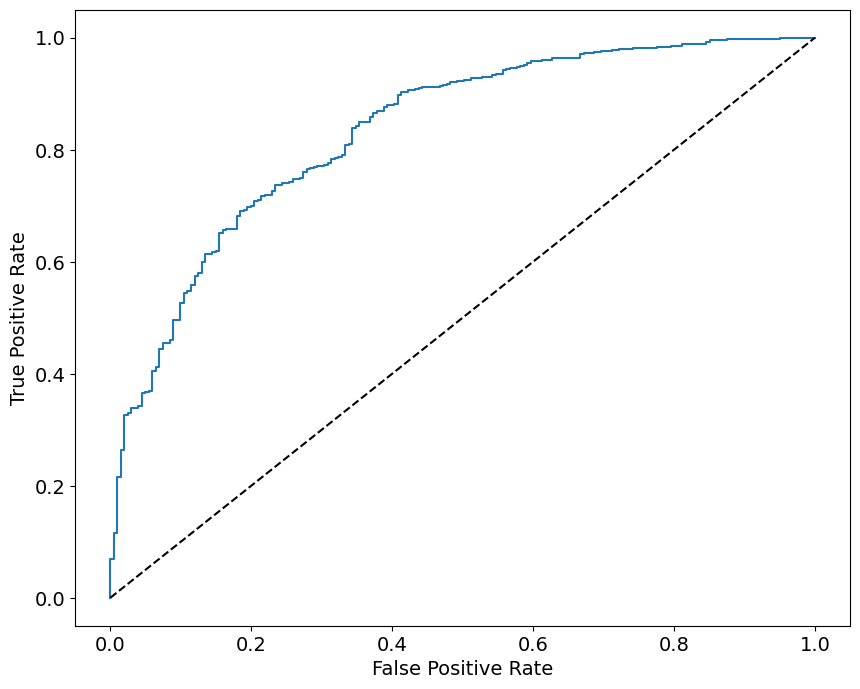

              precision    recall  f1-score   support

     not mel       0.71      0.39      0.51       201
         mel       0.86      0.96      0.90       757

    accuracy                           0.84       958
   macro avg       0.78      0.68      0.71       958
weighted avg       0.83      0.84      0.82       958



In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report
import os

# Ensure output directory exists
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

# Reset test_generator_mel to ensure it starts from the first sample
test_generator_mel.reset()

# Get the number of samples and batch size
num_samples = test_generator_mel.n  # Total number of samples (2013)
batch_size = test_generator_mel.batch_size  # 128
steps = int(np.ceil(num_samples / batch_size))  # 16

# Debug: Print number of samples, batch size, steps, and class indices
print(f"Number of test samples: {num_samples}")
print(f"Batch size: {batch_size}")
print(f"Steps: {steps}")
print(f"Class indices: {test_generator_mel.class_indices}")

# Predict probabilities using model2
predictions = model2.predict(test_generator_mel, steps=steps)

# Debug: Print shape of predictions
print(f"Shape of predictions: {predictions.shape}")

# Handle model output
if predictions.shape[1] == 2:
    y_pred_prob = predictions[:, 1]  # Softmax: probability for positive class ("nv")
elif predictions.shape[1] == 1:
    y_pred_prob = predictions.ravel()  # Sigmoid output
else:
    raise ValueError(f"Unexpected model output shape: {predictions.shape}")

y_pred = (y_pred_prob > 0.5).astype(int)

# Get true labels from test_generator_mel and convert to NumPy array
y_true = np.array(test_generator_mel.classes, dtype=np.int64)

# Debug: Print unique values, types, and sample labels
print(f"Unique y_true values: {np.unique(y_true)}")
print(f"y_true type: {type(y_true[0])}")
print(f"Sample y_true (first 10): {y_true[:10]}")
print(f"Sample y_pred (first 10): {y_pred[:10]}")
print(f"Length of y_true: {len(y_true)}")
print(f"Length of y_pred: {len(y_pred)}")
print(f"y_pred type: {type(y_pred[0])}")

# Ensure y_true and y_pred have the same length and type
assert len(y_true) == len(y_pred), f"Mismatch between y_true ({len(y_true)}) and y_pred ({len(y_pred)}) lengths"
assert isinstance(y_true[0], type(y_pred[0])), f"Type mismatch: y_true ({type(y_true[0])}), y_pred ({type(y_pred[0])})"

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['not mel', 'mel']

# Compute accuracy from confusion matrix
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"Accuracy from confusion matrix: {accuracy:.2%}")

# Plot and Save Confusion Matrix as Heatmap using Seaborn
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 14})
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# plt.title('Confusion Matrix Heatmap (Model1)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(os.path.join(output_dir, 'confusion_matrix_heatmap_model2.png'), dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# # Plot and Save Confusion Matrix using ConfusionMatrixDisplay
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
# disp.plot(cmap='Blues')
# plt.title('Confusion Matrix (Model1)')
# plt.savefig(os.path.join(output_dir, 'confusion_matrix_display_model2.png'), dpi=300, bbox_inches='tight')
# plt.show()
# plt.close()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 14})
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC Curve (Model1)')
# plt.legend(loc='lower right')
plt.savefig(os.path.join(output_dir, 'roc_curve_model2.png'), dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# Save Classification Report to a text file
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)
with open(os.path.join(output_dir, 'classification_report_model2.txt'), 'w') as f:
    f.write(report)

Pigmented Benign keratosis

In [52]:
mel_indices= metadata[metadata['diagnosis'] == 'melanoma'].index

In [53]:
train_ind_bkl=np.setdiff1d(train_ind_filtered,mel_indices)
test_ind_bkl=np.setdiff1d(test_ind_filtered,mel_indices)

In [54]:
BATCH_SiZE = 32

train_datagen = ImageDataGenerator(validation_split=0.1, rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)
    
train_generator_bkl = train_datagen.flow_from_dataframe(
    dataframe = metadata[metadata.index.isin(train_ind_bkl)],
    #     directory = None,
    x_col = 'isic_id',
    y_col = 'is_bkl',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical',
    batch_size = BATCH_SiZE,
    #     shuffle = True,
    subset = 'training',
    )


test_generator_bkl = test_datagen.flow_from_dataframe(
    dataframe = metadata[metadata.index.isin(test_ind_bkl)],
#     directory = images_dir,
    x_col = 'isic_id',
    y_col = 'is_bkl',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical',
    batch_size = BATCH_SiZE,
    shuffle = False,
)

Found 2374 validated image filenames belonging to 2 classes.
Found 757 validated image filenames belonging to 2 classes.


In [55]:
# Define the CNN model
model3 = Sequential()

# Add convolutional layers
model3.add(Conv2D(32, (11, 11), activation='relu', input_shape=(224, 224, 3)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(4, 4)))

model3.add(Conv2D(64, (7, 7), activation='tanh'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(128, (5, 5), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(128, (3, 3), activation='tanh'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output
model3.add(Flatten())

# Add fully connected layers
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))  # Dropout for regularization

model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.3))

model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.2))

# Output layer (number of classes for HAM10000 dataset)
model3.add(Dense(2, activation='softmax'))

model3.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 214, 214, 32)        │          11,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 53, 53, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 47, 47, 64)          │         100,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 19, 19, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 622,562 (2.37 MB)

 Trainable params: 622,562 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
from keras.optimizers import Adam
MAX_EPOCH=50
# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.0001)
# Compile the model with the correct optimizer and loss
model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save the best model
model_checkpoint = ModelCheckpoint('binary_cascading_bkl.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the model using batch processing with fit_generator
history = model3.fit(train_generator_bkl, validation_data=test_generator_bkl, 
                    epochs=MAX_EPOCH, 
#                     steps_per_epoch=len(X_train) // 32,
#                     validation_steps=len(X_val) // 32,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 496ms/step - accuracy: 0.6871 - loss: 0.6302 - val_accuracy: 0.7345 - val_loss: 0.5631
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 441ms/step - accuracy: 0.7226 - loss: 0.5859 - val_accuracy: 0.7345 - val_loss: 0.5705
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 452ms/step - accuracy: 0.7326 - loss: 0.5668 - val_accuracy: 0.7358 - val_loss: 0.5235
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 424ms/step - accuracy: 0.7320 - loss: 0.5521 - val_accuracy: 0.7318 - val_loss: 0.5090
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 425ms/step - accuracy: 0.7388 - loss: 0.5538 - val_accuracy: 0.7358 - val_loss: 0.4787
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 436ms/step - accuracy: 0.7468 - loss: 0.5110 - val_accuracy: 0.7609 - val_loss: 0.4651
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 435ms/step - accuracy: 0.7749 - loss: 0.4709 - val_accuracy: 0.7675 - val_loss: 0.4218
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 430ms/step - accuracy: 0.7533 - loss: 0.5119 - val_accuracy: 0.795

In [57]:
test_loss, test_acc = model3.evaluate(test_generator_bkl)
print(f"Test Accuracy: {test_acc}")

# Save the trained model
model3.save('binary_cascading_bkl.keras')

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 383ms/step - accuracy: 0.8853 - loss: 0.2625
Test Accuracy: 0.8731836080551147


In [58]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# 1. Predict
y_pred_prob = model3.predict(test_generator_bkl)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# 2. True labels
y_true = test_generator_bkl.classes

# 3. Get classification report as dictionary
report_dict = classification_report(
    y_true, y_pred_classes, 
    target_names=test_generator_bkl.class_indices.keys(), 
    output_dict=True
)

# 4. Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# 5. Format:
def format_value_full(x):
    if isinstance(x, (int, np.integer)):
        return int(x)
    elif isinstance(x, (float, np.floating)):
        return float(x)  # No rounding
    else:
        return x

report_df = report_df.applymap(format_value_full)

print(report_df)

# 6. Optional: Save to Excel
report_df.to_excel('classification_report_full_precision_3.xlsx', index=True)

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 343ms/step
                            precision    recall  f1-score     support
not bkl                      0.895189  0.937050  0.915641  556.000000
pigmented benign keratosis   0.800000  0.696517  0.744681  201.000000
accuracy                     0.873184  0.873184  0.873184    0.873184
macro avg                    0.847595  0.816784  0.830161  757.000000
weighted avg                 0.869914  0.873184  0.870248  757.000000


<ipython-input-58-ab25697ac8b3>:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  report_df = report_df.applymap(format_value_full)


In [59]:
test_generator_bkl.class_indices

{'not bkl': 0, 'pigmented benign keratosis': 1}

In [60]:
import pandas as pd
from sklearn.metrics import roc_curve

# 1. Get true labels
y_true = test_generator_bkl.classes

# 2. Predict PROBABILITIES
y_pred_prob = model3.predict(test_generator_bkl)

# 3. Take probability for class 1
y_pred_prob_class1 = y_pred_prob[:, 1]

# 4. Compute FPR, TPR, Thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob_class1)

# 5. Create a DataFrame
roc_data = pd.DataFrame({
    'False Positive Rate (FPR)': fpr,
    'True Positive Rate (TPR)': tpr,
    'Thresholds': thresholds
})

# 6. Save to Excel
roc_data.to_excel('roc_data_bkl.xlsx', index=False)

print("ROC data saved successfully to 'roc_data.xlsx'.")

24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 317ms/step
ROC data saved successfully to 'roc_data.xlsx'.


Number of test samples: 757
Batch size: 32
Steps: 24
Class indices: {'not bkl': 0, 'pigmented benign keratosis': 1}
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 325ms/step
Shape of predictions: (757, 2)
Unique y_true values: [0 1]
y_true type: <class 'numpy.int64'>
Sample y_true (first 10): [0 1 1 1 0 0 1 0 0 0]
Sample y_pred (first 10): [0 1 1 1 0 0 0 0 0 0]
Length of y_true: 757
Length of y_pred: 757
y_pred type: <class 'numpy.int64'>
Accuracy from confusion matrix: 87.32%


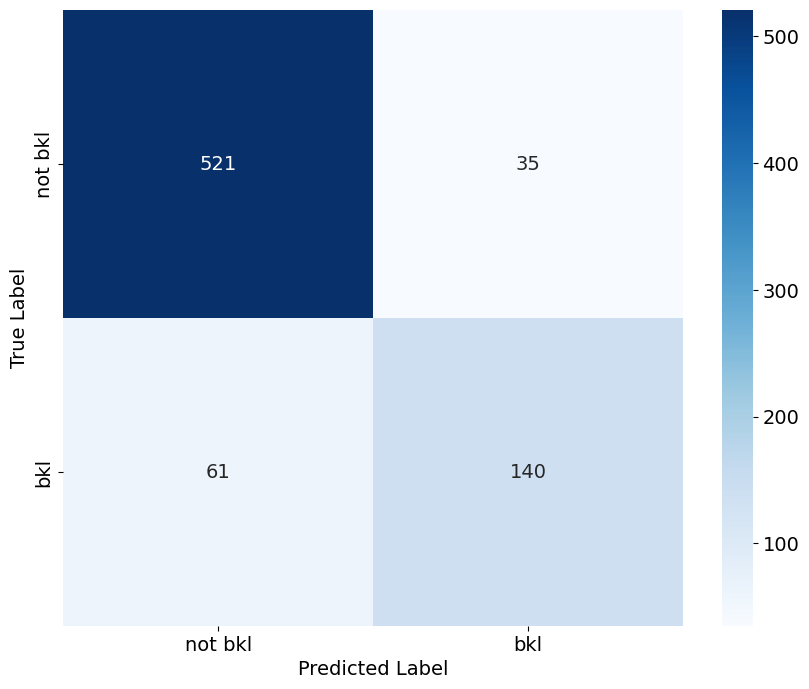

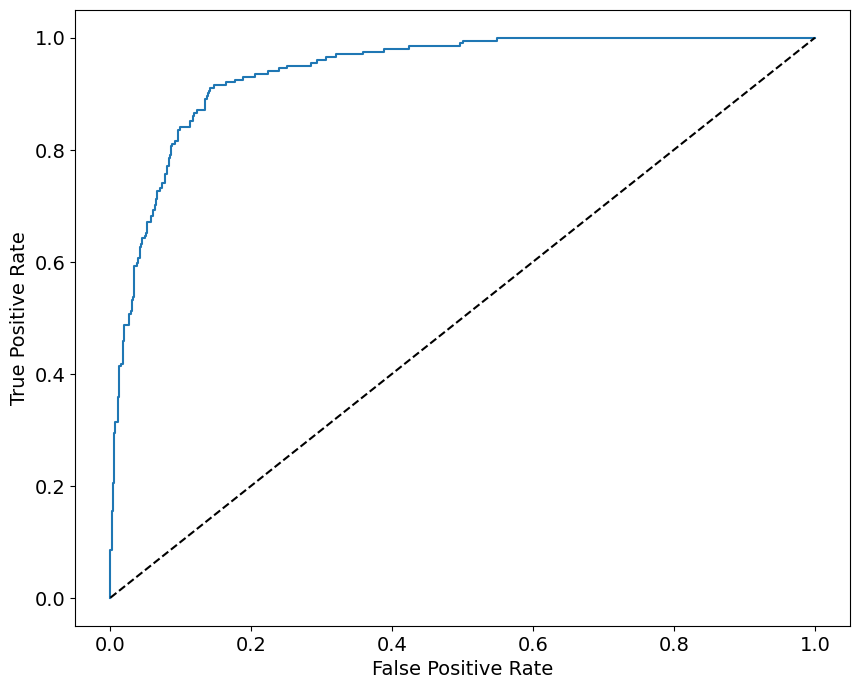

              precision    recall  f1-score   support

     not bkl       0.90      0.94      0.92       556
         bkl       0.80      0.70      0.74       201

    accuracy                           0.87       757
   macro avg       0.85      0.82      0.83       757
weighted avg       0.87      0.87      0.87       757



In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report
import os

# Ensure output directory exists
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

# Reset test_generator_bkl to ensure it starts from the first sample
test_generator_bkl.reset()

# Get the number of samples and batch size
num_samples = test_generator_bkl.n  # Total number of samples (2013)
batch_size = test_generator_bkl.batch_size  # 128
steps = int(np.ceil(num_samples / batch_size))  # 16

# Debug: Print number of samples, batch size, steps, and class indices
print(f"Number of test samples: {num_samples}")
print(f"Batch size: {batch_size}")
print(f"Steps: {steps}")
print(f"Class indices: {test_generator_bkl.class_indices}")

# Predict probabilities using model2
predictions = model3.predict(test_generator_bkl, steps=steps)

# Debug: Print shape of predictions
print(f"Shape of predictions: {predictions.shape}")

# Handle model output
if predictions.shape[1] == 2:
    y_pred_prob = predictions[:, 1]  # Softmax: probability for positive class ("nv")
elif predictions.shape[1] == 1:
    y_pred_prob = predictions.ravel()  # Sigmoid output
else:
    raise ValueError(f"Unexpected model output shape: {predictions.shape}")

y_pred = (y_pred_prob > 0.5).astype(int)

# Get true labels from test_generator_bkl and convert to NumPy array
y_true = np.array(test_generator_bkl.classes, dtype=np.int64)

# Debug: Print unique values, types, and sample labels
print(f"Unique y_true values: {np.unique(y_true)}")
print(f"y_true type: {type(y_true[0])}")
print(f"Sample y_true (first 10): {y_true[:10]}")
print(f"Sample y_pred (first 10): {y_pred[:10]}")
print(f"Length of y_true: {len(y_true)}")
print(f"Length of y_pred: {len(y_pred)}")
print(f"y_pred type: {type(y_pred[0])}")

# Ensure y_true and y_pred have the same length and type
assert len(y_true) == len(y_pred), f"Mismatch between y_true ({len(y_true)}) and y_pred ({len(y_pred)}) lengths"
assert isinstance(y_true[0], type(y_pred[0])), f"Type mismatch: y_true ({type(y_true[0])}), y_pred ({type(y_pred[0])})"

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['not bkl', 'bkl']

# Compute accuracy from confusion matrix
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"Accuracy from confusion matrix: {accuracy:.2%}")

# Plot and Save Confusion Matrix as Heatmap using Seaborn
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 14})
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# plt.title('Confusion Matrix Heatmap (Model1)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(os.path.join(output_dir, 'confusion_matrix_heatmap_model3.png'), dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# # Plot and Save Confusion Matrix using ConfusionMatrixDisplay
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
# disp.plot(cmap='Blues')
# plt.title('Confusion Matrix (Model1)')
# plt.savefig(os.path.join(output_dir, 'confusion_matrix_display_model2.png'), dpi=300, bbox_inches='tight')
# plt.show()
# plt.close()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 14})
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC Curve (Model1)')
# plt.legend(loc='lower right')
plt.savefig(os.path.join(output_dir, 'roc_curve_model3.png'), dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# Save Classification Report to a text file
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)
with open(os.path.join(output_dir, 'classification_report_model3.txt'), 'w') as f:
    f.write(report)

Basal cell carcinoma

In [62]:
bkl_indices= metadata[metadata['diagnosis'] == 'pigmented benign keratosis'].index

In [63]:
train_ind_bcc=np.setdiff1d(train_ind_bkl,bkl_indices)
test_ind_bcc=np.setdiff1d(test_ind_bkl,bkl_indices)

In [64]:
BATCH_SiZE = 32

train_datagen = ImageDataGenerator(validation_split=0.1, rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)
    
train_generator_bcc = train_datagen.flow_from_dataframe(
    dataframe = metadata[metadata.index.isin(train_ind_bcc)],
    #     directory = None,
    x_col = 'isic_id',
    y_col = 'is_bcc',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical',
    batch_size = BATCH_SiZE,
    #     shuffle = True,
    subset = 'training',
    )


test_generator_bcc = test_datagen.flow_from_dataframe(
    dataframe = metadata[metadata.index.isin(test_ind_bcc)],
#     directory = images_dir,
    x_col = 'isic_id',
    y_col = 'is_bcc',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical',
    batch_size = BATCH_SiZE,
    shuffle = False,
)

Found 1744 validated image filenames belonging to 2 classes.
Found 556 validated image filenames belonging to 2 classes.


In [65]:
# Define the CNN model
model4 = Sequential()

# Add convolutional layers
model4.add(Conv2D(32, (11, 11), activation='relu', input_shape=(224, 224, 3)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(4, 4)))

model4.add(Conv2D(64, (7, 7), activation='tanh'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Conv2D(128, (5, 5), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Conv2D(128, (3, 3), activation='tanh'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output
model4.add(Flatten())

# Add fully connected layers
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.5))  # Dropout for regularization

model4.add(Dense(64, activation='relu'))
model4.add(Dropout(0.3))

model4.add(Dense(32, activation='relu'))
model4.add(Dropout(0.2))

# Output layer (number of classes for HAM10000 dataset)
model4.add(Dense(2, activation='softmax'))

model4.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 214, 214, 32)        │          11,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 53, 53, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 47, 47, 64)          │         100,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 19, 19, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 622,562 (2.37 MB)

 Trainable params: 622,562 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
from keras.optimizers import Adam
MAX_EPOCH=50
# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.0001)
# Compile the model with the correct optimizer and loss
model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save the best model
model_checkpoint = ModelCheckpoint('binary_cascading_3.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the model using batch processing with fit_generator
history = model4.fit(train_generator_bcc, validation_data=test_generator_bcc, 
                    epochs=MAX_EPOCH, 
#                     steps_per_epoch=len(X_train) // 32,
#                     validation_steps=len(X_val) // 32,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 43s 641ms/step - accuracy: 0.5906 - loss: 0.6785 - val_accuracy: 0.6385 - val_loss: 0.6629
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 533ms/step - accuracy: 0.6321 - loss: 0.6746 - val_accuracy: 0.6385 - val_loss: 0.6656
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 538ms/step - accuracy: 0.6390 - loss: 0.6650 - val_accuracy: 0.6385 - val_loss: 0.6603
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 527ms/step - accuracy: 0.6305 - loss: 0.6635 - val_accuracy: 0.6385 - val_loss: 0.6563
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 523ms/step - accuracy: 0.6340 - loss: 0.6623 - val_accuracy: 0.6385 - val_loss: 0.6602
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 527ms/step - accuracy: 0.6178 - loss: 0.6667 - val_accuracy: 0.6385 - val_loss: 0.6544
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 534ms/step - accuracy: 0.6301 - loss: 0.6694 - val_accuracy: 0.6385 - val_loss: 0.6509
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 524ms/step - accuracy: 0.6374 - loss: 0.6656 - val_accuracy: 0.638

In [67]:
test_loss, test_acc = model4.evaluate(test_generator_bcc)
print(f"Test Accuracy: {test_acc}")

# Save the trained model
model4.save('binary_cascading_bcc.keras')

18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 398ms/step - accuracy: 0.6211 - loss: 0.6583
Test Accuracy: 0.6384891867637634


In [68]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# 1. Predict
y_pred_prob = model4.predict(test_generator_bcc)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# 2. True labels
y_true = test_generator_bcc.classes

# 3. Get classification report as dictionary
report_dict = classification_report(
    y_true, y_pred_classes, 
    target_names=test_generator_bcc.class_indices.keys(), 
    output_dict=True
)

# 4. Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# 5. Format:
def format_value_full(x):
    if isinstance(x, (int, np.integer)):
        return int(x)
    elif isinstance(x, (float, np.floating)):
        return float(x)  # No rounding
    else:
        return x

report_df = report_df.applymap(format_value_full)

print(report_df)

# 6. Optional: Save to Excel
report_df.to_excel('classification_report_full_precision_4.xlsx', index=True)

18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 403ms/step
                      precision    recall  f1-score     support
basal cell carcinoma   0.000000  0.000000  0.000000  201.000000
not bcc                0.638489  1.000000  0.779363  355.000000
accuracy               0.638489  0.638489  0.638489    0.638489
macro avg              0.319245  0.500000  0.389682  556.000000
weighted avg           0.407668  0.638489  0.497615  556.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-68-c7ffa5b59d4c>:31: FutureWarning: DataFrame.app

In [69]:
test_generator_bcc.class_indices

{'basal cell carcinoma': 0, 'not bcc': 1}

In [70]:
import pandas as pd
from sklearn.metrics import roc_curve

# 1. Get true labels
y_true = test_generator_bcc.classes

# 2. Predict PROBABILITIES
y_pred_prob = model4.predict(test_generator_bcc)

# 3. Take probability for class 1
y_pred_prob_class1 = y_pred_prob[:, 1]

# 4. Compute FPR, TPR, Thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob_class1)

# 5. Create a DataFrame
roc_data = pd.DataFrame({
    'False Positive Rate (FPR)': fpr,
    'True Positive Rate (TPR)': tpr,
    'Thresholds': thresholds
})

# 6. Save to Excel
roc_data.to_excel('roc_data_bcc.xlsx', index=False)

print("ROC data saved successfully to 'roc_data.xlsx'.")

18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 390ms/step
ROC data saved successfully to 'roc_data.xlsx'.


Number of test samples: 556
Batch size: 32
Steps: 18
Class indices: {'basal cell carcinoma': 0, 'not bcc': 1}
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 392ms/step
Shape of predictions: (556, 2)
Unique y_true values: [0 1]
y_true type: <class 'numpy.int64'>
Sample y_true (first 10): [0 1 1 0 0 0 1 1 1 1]
Sample y_pred (first 10): [1 1 1 1 1 1 1 1 1 1]
Length of y_true: 556
Length of y_pred: 556
y_pred type: <class 'numpy.int64'>
Accuracy from confusion matrix: 63.85%


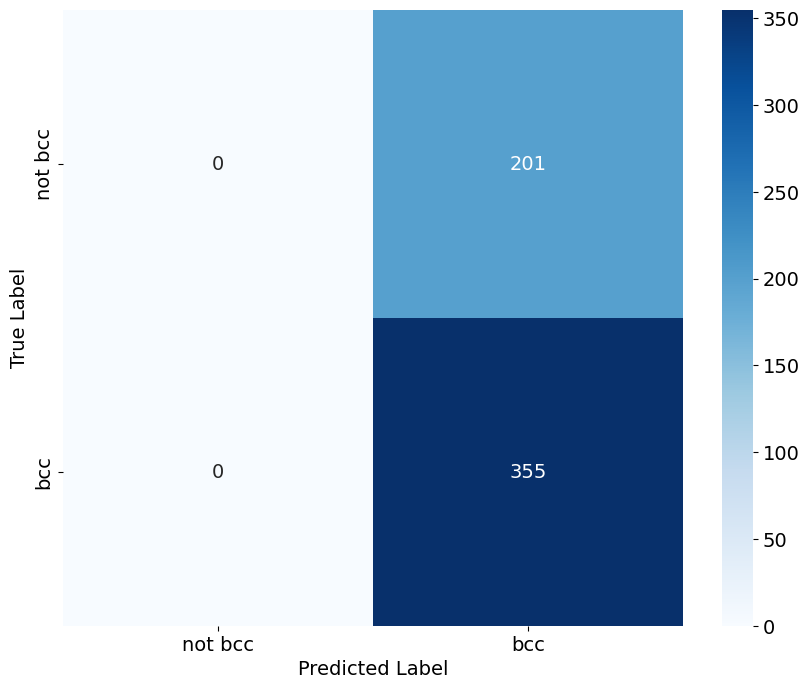

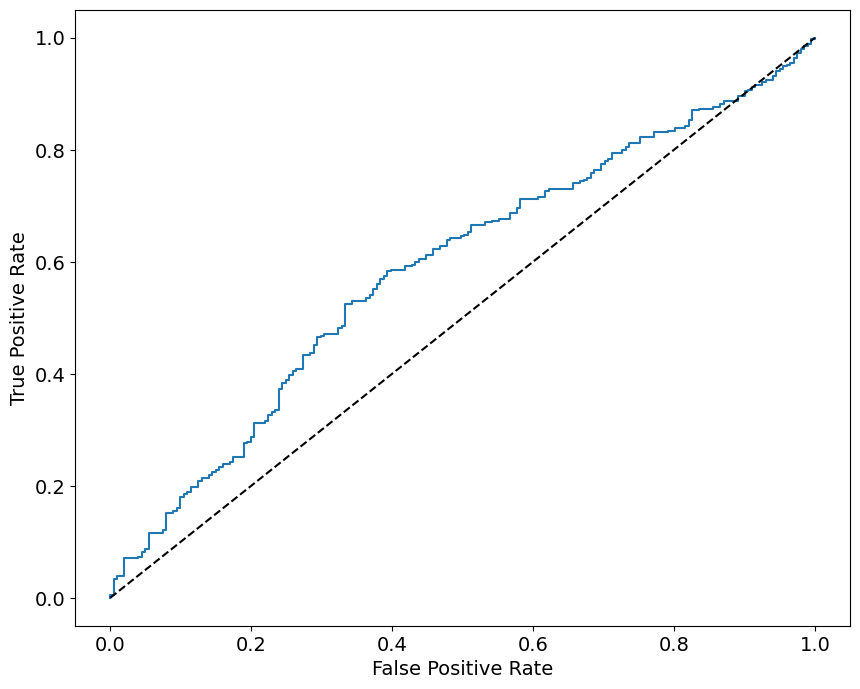

              precision    recall  f1-score   support

     not bcc       0.00      0.00      0.00       201
         bcc       0.64      1.00      0.78       355

    accuracy                           0.64       556
   macro avg       0.32      0.50      0.39       556
weighted avg       0.41      0.64      0.50       556



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report
import os

# Ensure output directory exists
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

# Reset test_generator_bcc to ensure it starts from the first sample
test_generator_bcc.reset()

# Get the number of samples and batch size
num_samples = test_generator_bcc.n  # Total number of samples (2013)
batch_size = test_generator_bcc.batch_size  # 128
steps = int(np.ceil(num_samples / batch_size))  # 16

# Debug: Print number of samples, batch size, steps, and class indices
print(f"Number of test samples: {num_samples}")
print(f"Batch size: {batch_size}")
print(f"Steps: {steps}")
print(f"Class indices: {test_generator_bcc.class_indices}")

# Predict probabilities using model2
predictions = model4.predict(test_generator_bcc, steps=steps)

# Debug: Print shape of predictions
print(f"Shape of predictions: {predictions.shape}")

# Handle model output
if predictions.shape[1] == 2:
    y_pred_prob = predictions[:, 1]  # Softmax: probability for positive class ("nv")
elif predictions.shape[1] == 1:
    y_pred_prob = predictions.ravel()  # Sigmoid output
else:
    raise ValueError(f"Unexpected model output shape: {predictions.shape}")

y_pred = (y_pred_prob > 0.5).astype(int)

# Get true labels from test_generator_bcc and convert to NumPy array
y_true = np.array(test_generator_bcc.classes, dtype=np.int64)

# Debug: Print unique values, types, and sample labels
print(f"Unique y_true values: {np.unique(y_true)}")
print(f"y_true type: {type(y_true[0])}")
print(f"Sample y_true (first 10): {y_true[:10]}")
print(f"Sample y_pred (first 10): {y_pred[:10]}")
print(f"Length of y_true: {len(y_true)}")
print(f"Length of y_pred: {len(y_pred)}")
print(f"y_pred type: {type(y_pred[0])}")

# Ensure y_true and y_pred have the same length and type
assert len(y_true) == len(y_pred), f"Mismatch between y_true ({len(y_true)}) and y_pred ({len(y_pred)}) lengths"
assert isinstance(y_true[0], type(y_pred[0])), f"Type mismatch: y_true ({type(y_true[0])}), y_pred ({type(y_pred[0])})"

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['not bcc', 'bcc']

# Compute accuracy from confusion matrix
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"Accuracy from confusion matrix: {accuracy:.2%}")

# Plot and Save Confusion Matrix as Heatmap using Seaborn
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 14})
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# plt.title('Confusion Matrix Heatmap (Model1)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(os.path.join(output_dir, 'confusion_matrix_heatmap_model4.png'), dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# # Plot and Save Confusion Matrix using ConfusionMatrixDisplay
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
# disp.plot(cmap='Blues')
# plt.title('Confusion Matrix (Model1)')
# plt.savefig(os.path.join(output_dir, 'confusion_matrix_display_model2.png'), dpi=300, bbox_inches='tight')
# plt.show()
# plt.close()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 14})
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC Curve (Model1)')
# plt.legend(loc='lower right')
plt.savefig(os.path.join(output_dir, 'roc_curve_model4.png'), dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# Save Classification Report to a text file
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)
with open(os.path.join(output_dir, 'classification_report_model4.txt'), 'w') as f:
    f.write(report)

Actinic keratosis

In [72]:
# import pandas as pd

# filtered_metadata = pd.read_csv("filtered_metadata.csv") #load the csv file.
bcc_indices = metadata[metadata['diagnosis'] == 'basal cell carcinoma'].index

In [84]:
# import pandas as pd
# import numpy as np

# # Assuming you have the same metadata DataFrame and indices:
# data = {'isic_id': ['img1', 'img2', 'img3', 'img4'],
#         'is_akiec': [1, 0, 1, 0]}  # Notice the labels are already binary
# metadata = pd.DataFrame(data)

# train_ind_akiec = ['img1', 'img2']
# test_ind_akiec = ['img3', 'img4']

# # Reverse the binary to string conversion
# metadata['is_akiec_str'] = np.where(metadata['is_akiec'] == 1, 'akiec', 'not_akiec')

# # Now, you can use the string labels if needed
# print(metadata)

# # If you need to revert the generators, you simply change the y_col:

# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# IMG_HEIGHT = 100 #replace with your actual image height.
# IMG_WIDTH = 100 #replace with your actual image width.
# BATCH_SiZE = 32

# train_datagen = ImageDataGenerator(validation_split=0.1, rescale=1. / 255)
# test_datagen = ImageDataGenerator(rescale=1. / 255)

# train_generator_akiec_str = train_datagen.flow_from_dataframe(
#     dataframe=metadata[metadata['isic_id'].isin(train_ind_akiec)],
#     x_col='isic_id',
#     y_col='is_akiec_str',  # Use the string labels
#     target_size=(IMG_HEIGHT, IMG_WIDTH),
#     class_mode='categorical',
#     batch_size=BATCH_SiZE,
#     subset='training',
# )

# test_generator_akiec_str = test_datagen.flow_from_dataframe(
#     dataframe=metadata[metadata['isic_id'].isin(test_ind_akiec)],
#     x_col='isic_id',
#     y_col='is_akiec_str',  # Use the string labels
#     target_size=(IMG_HEIGHT, IMG_WIDTH),
#     class_mode='categorical',
#     batch_size=BATCH_SiZE,
#     shuffle=False,
# )

# print(train_generator_akiec_str.class_indices)
print(test_generator_akiec_str.class_indices)

NameError: name 'test_generator_akiec_str' is not defined

In [73]:
train_ind_akiec=np.setdiff1d(train_ind_bcc,bcc_indices)
test_ind_akiec=np.setdiff1d(test_ind_bcc,bcc_indices)

In [83]:
print(test_ind_akiec)

[  32   47   74   78   81   83  107  123  127  139  144  169  177  212
  213  276  308  326  329  396  404  425  428  481  491  495  506  516
  526  557  558  625  672  673  713  721  750  751  760  787  814  833
  858  859  914  915  932  945  959  982  993 1010 1020 1025 1072 1099
 1110 1117 1137 1138 1170 1198 1218 1273 1287 1300 1306 1311 1347 1362
 1366 1384 1400 1411 1435 1438 1508 1514 1535 1609 1617 1625 1646 1655
 1682 1689 1700 1729 1738 1747 1751 1764 1774 1791 1808 1818 1830 1838
 1850 1852 1892 1897 1955 1968 1985 2007 2011 2030 2115 2121 2168 2177
 2178 2181 2189 2202 2207 2209 2211 2245 2257 2258 2264 2275 2284 2295
 2306 2333 2334 2337 2342 2376 2377 2387 2427 2431 2448 2453 2537 2575
 2605 2665 2680 2697 2709 2713 2715 2730 2754 2763 2766 2772 2778 2781
 2782 2830 2884 2895 2898 2901 2937 2945 2948 2956 2978 2981 2991 3005
 3017 3122 3131 3156 3168 3173 3180 3185 3198 3209 3215 3232 3247 3290
 3292 3298 3319 3321 3323 3330 3334 3337 3344 3345 3372 3386 3400 3415
 3454 

In [ ]:
# import pandas as pd
# import numpy as np

# # Assuming filtered_metadata.csv has been loaded into the filtered_metadata dataframe.
# # Assuming metadata.csv has been loaded into the metadata dataframe.

# #create the is_akiec column in the filtered_metadata dataframe.
# filtered_metadata['is_akiec'] = np.where(filtered_metadata['diagnosis'] == 'actinic keratosis', 1, 0)

# #if you need to move the is_akiec column to the metadata dataframe, you will have to align the dataframes.

# #example of how to merge the dataframes if they have a shared column.
# metadata = pd.merge(metadata, filtered_metadata[['isic_id','is_akiec']], on = 'isic_id', how = 'left')

# #example of how to fill the nan values created by the left merge.
# metadata['is_akiec'] = metadata['is_akiec'].fillna(0)

# print(metadata)

In [74]:
BATCH_SiZE = 32

train_datagen = ImageDataGenerator(validation_split=0.1, rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)
    
train_generator_akiec = train_datagen.flow_from_dataframe(
    dataframe = metadata[metadata.index.isin(train_ind_akiec)],
    #     directory = None,
    x_col = 'isic_id',
    y_col = 'is_akiec',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical',
    batch_size = BATCH_SiZE,
    #     shuffle = True,
    subset = 'training',
    )

test_generator_akiec = test_datagen.flow_from_dataframe(
    dataframe = metadata[metadata.index.isin(test_ind_akiec)],
#     directory = images_dir,
    x_col = 'isic_id',
    y_col = 'is_akiec',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical',
    batch_size = BATCH_SiZE,
    shuffle = False,
)

Found 1114 validated image filenames belonging to 1 classes.
Found 355 validated image filenames belonging to 1 classes.


In [86]:
test_generator_akiec.class_indices

{'not akiec': 0}

In [ ]:
# print(metadata[metadata.index.isin(train_ind_akiec)]['is_akiec'].value_counts())
# print(metadata[metadata.index.isin(test_ind_akiec)]['is_akiec'].value_counts())

In [ ]:
# import pandas as pd

# # Load the already filtered metadata
# output_csv = "/kaggle/working/filtered_metadata.csv"
# final_df = pd.read_csv(output_csv)

# # Define the class you want to adjust
# target_class = "actinic keratosis"
# desired_count = 2000

# # Load the original metadata (if it's not already in memory)
# csv_path = "/kaggle/input/all-isic-data-20240629/metadata.csv"
# df = pd.read_csv(csv_path)

# # Filter the original dataframe for the target class
# target_class_df = df[df["diagnosis"] == target_class]

# # Calculate the difference between the desired count and the current count
# current_count = len(final_df[final_df["diagnosis"] == target_class])
# difference = desired_count - current_count

# if difference > 0:
#     # Sample additional images from the original dataframe
#     additional_images = target_class_df.sample(n=difference, replace=(difference > len(target_class_df)), random_state=42)

#     # Append the additional images to the final dataframe
#     final_df = pd.concat([final_df, additional_images])
#     print(f"Added {difference} images for {target_class}.")

# elif difference < 0:
#     #Remove images from the final dataframe until the count is correct.
#     remove_num = abs(difference)
#     remove_indexes = final_df[final_df['diagnosis'] == target_class].sample(n=remove_num, random_state = 42).index
#     final_df = final_df.drop(remove_indexes)
#     print(f"Removed {remove_num} images for {target_class}.")
# else:
#     print(f"Image count for {target_class} is already {desired_count}.")

# # Shuffle the final dataframe again
# final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

# # Save the updated metadata
# final_df.to_csv(output_csv, index=False)
# print(f"Updated metadata saved to: {output_csv}")

# # Print the updated image count per class
# print("\nUpdated image count per selected class:")
# print(final_df["diagnosis"].value_counts())

In [ ]:
# print(metadata[metadata.index.isin(train_ind_akiec)]['is_akiec'].value_counts())
# print(metadata[metadata.index.isin(test_ind_akiec)]['is_akiec'].value_counts())

In [ ]:
# print(train_ind_akiec)
# print(test_ind_akiec)

In [75]:
# Define the CNN model
model5 = Sequential()

# Add convolutional layers
model5.add(Conv2D(32, (11, 11), activation='relu', input_shape=(224, 224, 3)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(4, 4)))

model5.add(Conv2D(64, (7, 7), activation='tanh'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Conv2D(128, (5, 5), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Conv2D(128, (3, 3), activation='tanh'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output
model5.add(Flatten())

# Add fully connected layers
model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.5))  # Dropout for regularization

model5.add(Dense(64, activation='relu'))
model5.add(Dropout(0.3))

model5.add(Dense(32, activation='relu'))
model5.add(Dropout(0.2))

# Output layer (number of classes for HAM10000 dataset)
model5.add(Dense(2, activation='softmax'))

model5.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 214, 214, 32)        │          11,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 53, 53, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 47, 47, 64)          │         100,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 19, 19, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 622,562 (2.37 MB)

 Trainable params: 622,562 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
from keras.optimizers import Adam
MAX_EPOCH=50
# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.0001)
# Compile the model with the correct optimizer and loss
model5.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save the best model
model_checkpoint = ModelCheckpoint('binary_cascading_akiec.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the model using batch processing with fit_generator
history = model5.fit(train_generator_akiec, validation_data=test_generator_akiec, 
                    epochs=MAX_EPOCH, 
#                     steps_per_epoch=len(X_train) // 32,
#                     validation_steps=len(X_val) // 32,
                    callbacks=[early_stopping, model_checkpoint])


# # Define the optimizer
# optimizer = Adam(learning_rate=0.0001)

# # Compile the model
# model5.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Model checkpoint
# model_checkpoint = ModelCheckpoint('binary_cascading_akiec.keras', save_best_only=True, monitor='val_loss', mode='min')

# # Calculate steps per epoch and validation steps
# steps_per_epoch = len(train_generator_akiec)
# validation_steps = len(test_generator_akiec)

# # Train the model
# history = model5.fit(
#     train_generator_akiec,
#     validation_data=test_generator_akiec,
#     epochs=50,  # MAX_EPOCH
#     steps_per_epoch=steps_per_epoch,
#     validation_steps=validation_steps,
#     callbacks=[early_stopping, model_checkpoint]
# )

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 31s 658ms/step - accuracy: 0.9312 - loss: 0.2880 - val_accuracy: 1.0000 - val_loss: 2.8993e-06
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 506ms/step - accuracy: 0.9998 - loss: 0.0056 - val_accuracy: 1.0000 - val_loss: 4.4561e-07
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 513ms/step - accuracy: 0.9964 - loss: 0.0104 - val_accuracy: 1.0000 - val_loss: 1.3063e-07
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 499ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 4.7012e-09
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 506ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 3.3580e-10
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 507ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 519ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 501ms/step - accuracy: 1.0000 - loss: 

In [77]:
test_loss, test_acc = model5.evaluate(test_generator_akiec)
print(f"Test Accuracy: {test_acc}")

# Save the trained model
model5.save('binary_cascading_akiec.keras')

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 386ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Test Accuracy: 1.0


In [78]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# 1. Predict
y_pred_prob = model5.predict(test_generator_akiec)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# 2. True labels
y_true = test_generator_akiec.classes

# 3. Get classification report as dictionary
report_dict = classification_report(
    y_true, y_pred_classes, 
    target_names=test_generator_akiec.class_indices.keys(), 
    output_dict=True
)

# 4. Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# 5. Format:
def format_value_full(x):
    if isinstance(x, (int, np.integer)):
        return int(x)
    elif isinstance(x, (float, np.floating)):
        return float(x)  # No rounding
    else:
        return x

report_df = report_df.applymap(format_value_full)

print(report_df)

# 6. Optional: Save to Excel
report_df.to_excel('classification_report_full_precision_5.xlsx', index=True)

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 382ms/step


ValueError: Number of classes, 2, does not match size of target_names, 1. Try specifying the labels parameter

In [88]:
test_generator_akiec.class_indices

{'not akiec': 0}

In [89]:
import pandas as pd
from sklearn.metrics import roc_curve

# 1. Get true labels
y_true = test_generator_akiec.classes

# 2. Predict PROBABILITIES
y_pred_prob = model5.predict(test_generator_akiec)

# 3. Take probability for class 1
y_pred_prob_class1 = y_pred_prob[:, 1]

# 4. Compute FPR, TPR, Thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob_class1)

# 5. Create a DataFrame
roc_data = pd.DataFrame({
    'False Positive Rate (FPR)': fpr,
    'True Positive Rate (TPR)': tpr,
    'Thresholds': thresholds
})

# 6. Save to Excel
roc_data.to_excel('roc_data_akiec.xlsx', index=False)

print("ROC data saved successfully to 'roc_data.xlsx'.")

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 413ms/step
ROC data saved successfully to 'roc_data.xlsx'.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Number of test samples: 355
Batch size: 32
Steps: 12
Class indices: {'not akiec': 0}
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 383ms/step
Shape of predictions: (355, 2)
Unique y_true values: [0]
y_true type: <class 'numpy.int64'>
Sample y_true (first 10): [0 0 0 0 0 0 0 0 0 0]
Sample y_pred (first 10): [1 1 1 1 1 1 1 1 1 1]
Length of y_true: 355
Length of y_pred: 355
y_pred type: <class 'numpy.int64'>
Accuracy from confusion matrix: 0.00%


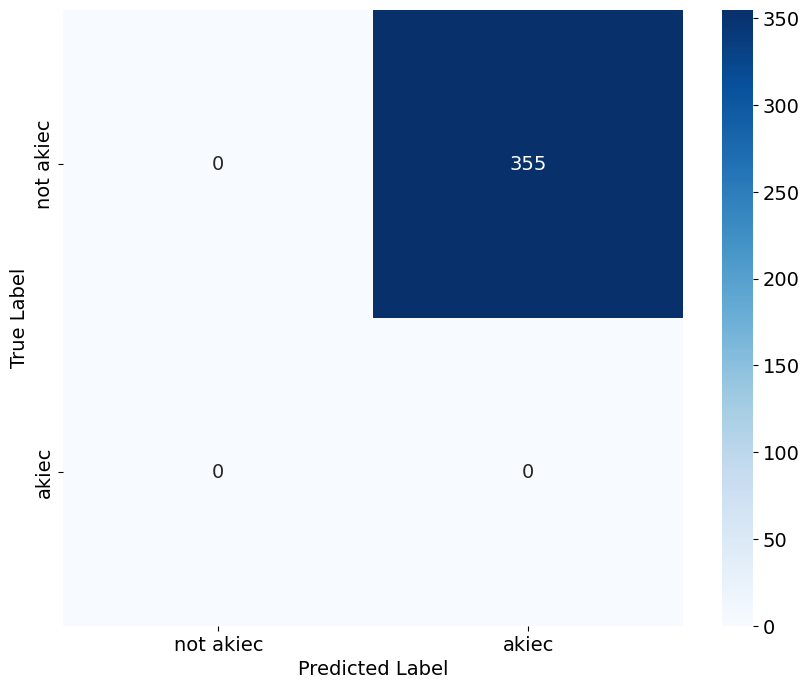

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


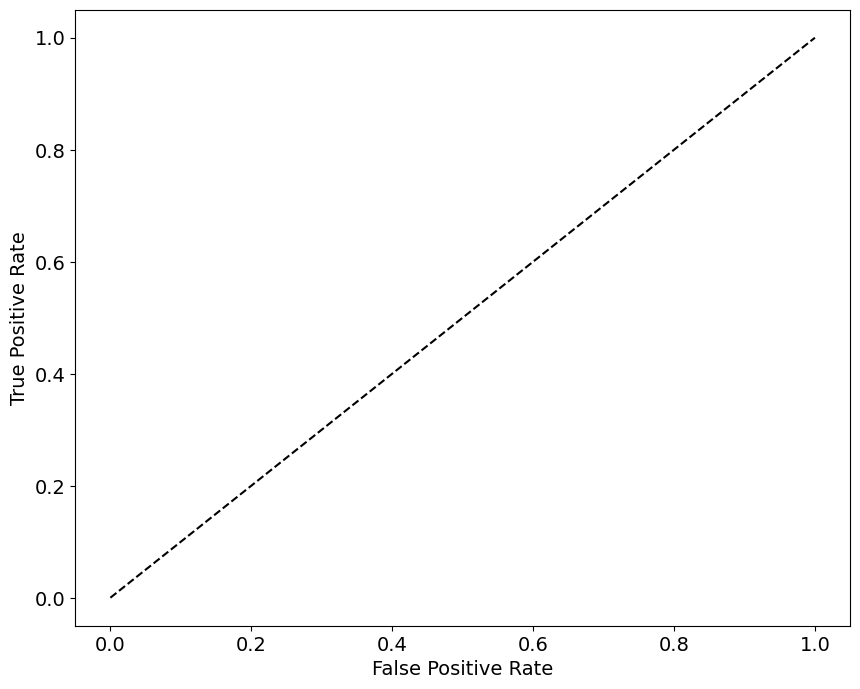

              precision    recall  f1-score   support

   not akiec       0.00      0.00      0.00     355.0
       akiec       0.00      0.00      0.00       0.0

    accuracy                           0.00     355.0
   macro avg       0.00      0.00      0.00     355.0
weighted avg       0.00      0.00      0.00     355.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report
import os

# Ensure output directory exists
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

# Reset test_generator_akiec to ensure it starts from the first sample
test_generator_akiec.reset()

# Get the number of samples and batch size
num_samples = test_generator_akiec.n  # Total number of samples (2013)
batch_size = test_generator_akiec.batch_size  # 128
steps = int(np.ceil(num_samples / batch_size))  # 16

# Debug: Print number of samples, batch size, steps, and class indices
print(f"Number of test samples: {num_samples}")
print(f"Batch size: {batch_size}")
print(f"Steps: {steps}")
print(f"Class indices: {test_generator_akiec.class_indices}")

# Predict probabilities using model2
predictions = model5.predict(test_generator_akiec, steps=steps)

# Debug: Print shape of predictions
print(f"Shape of predictions: {predictions.shape}")

# Handle model output
if predictions.shape[1] == 2:
    y_pred_prob = predictions[:, 1]  # Softmax: probability for positive class ("nv")
elif predictions.shape[1] == 1:
    y_pred_prob = predictions.ravel()  # Sigmoid output
else:
    raise ValueError(f"Unexpected model output shape: {predictions.shape}")

y_pred = (y_pred_prob > 0.5).astype(int)

# Get true labels from test_generator_akiec and convert to NumPy array
y_true = np.array(test_generator_akiec.classes, dtype=np.int64)

# Debug: Print unique values, types, and sample labels
print(f"Unique y_true values: {np.unique(y_true)}")
print(f"y_true type: {type(y_true[0])}")
print(f"Sample y_true (first 10): {y_true[:10]}")
print(f"Sample y_pred (first 10): {y_pred[:10]}")
print(f"Length of y_true: {len(y_true)}")
print(f"Length of y_pred: {len(y_pred)}")
print(f"y_pred type: {type(y_pred[0])}")

# Ensure y_true and y_pred have the same length and type
assert len(y_true) == len(y_pred), f"Mismatch between y_true ({len(y_true)}) and y_pred ({len(y_pred)}) lengths"
assert isinstance(y_true[0], type(y_pred[0])), f"Type mismatch: y_true ({type(y_true[0])}), y_pred ({type(y_pred[0])})"

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['not akiec', 'akiec']

# Compute accuracy from confusion matrix
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"Accuracy from confusion matrix: {accuracy:.2%}")

# Plot and Save Confusion Matrix as Heatmap using Seaborn
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 14})
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# plt.title('Confusion Matrix Heatmap (Model1)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(os.path.join(output_dir, 'confusion_matrix_heatmap_model5.png'), dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# # Plot and Save Confusion Matrix using ConfusionMatrixDisplay
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
# disp.plot(cmap='Blues')
# plt.title('Confusion Matrix (Model1)')
# plt.savefig(os.path.join(output_dir, 'confusion_matrix_display_model2.png'), dpi=300, bbox_inches='tight')
# plt.show()
# plt.close()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 14})
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC Curve (Model1)')
# plt.legend(loc='lower right')
plt.savefig(os.path.join(output_dir, 'roc_curve_model5.png'), dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# Save Classification Report to a text file
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)
with open(os.path.join(output_dir, 'classification_report_model5.txt'), 'w') as f:
    f.write(report)

Vascular lesion vs Dermatofibroma              

In [91]:
akiec_indices= metadata[metadata['diagnosis'] == 'actinic keratosis'].index

In [92]:
train_ind_vasc=np.setdiff1d(train_ind_akiec,akiec_indices)
test_ind_vasc=np.setdiff1d(test_ind_akiec,akiec_indices)

In [93]:
BATCH_SiZE = 32

train_datagen = ImageDataGenerator(validation_split=0.1, rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)
    
train_generator_vasc = train_datagen.flow_from_dataframe(
    dataframe = metadata[metadata.index.isin(train_ind_vasc)],
    #     directory = None,
    x_col = 'isic_id',
    y_col = 'is_vasc',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical',
    batch_size = BATCH_SiZE,
    #     shuffle = True,
    subset = 'training',
    )

test_generator_vasc = test_datagen.flow_from_dataframe(
    dataframe = metadata[metadata.index.isin(test_ind_vasc)],
#     directory = images_dir,
    x_col = 'isic_id',
    y_col = 'is_vasc',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical',
    batch_size = BATCH_SiZE,
    shuffle = False,
)

Found 484 validated image filenames belonging to 2 classes.
Found 154 validated image filenames belonging to 2 classes.


In [94]:
# Define the CNN model
model6 = Sequential()

# Add convolutional layers
model6.add(Conv2D(32, (11, 11), activation='relu', input_shape=(224, 224, 3)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
model6.add(MaxPooling2D(pool_size=(4, 4)))

model6.add(Conv2D(64, (7, 7), activation='tanh'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

model6.add(Conv2D(128, (5, 5), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

model6.add(Conv2D(128, (3, 3), activation='tanh'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(Conv2D(256, (3, 3), activation='relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output
model6.add(Flatten())

# Add fully connected layers
model6.add(Dense(128, activation='relu'))
model6.add(Dropout(0.5))  # Dropout for regularization

model6.add(Dense(64, activation='relu'))
model6.add(Dropout(0.3))

model6.add(Dense(32, activation='relu'))
model6.add(Dropout(0.2))

# Output layer (number of classes for HAM10000 dataset)
model6.add(Dense(2, activation='softmax'))

model6.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 214, 214, 32)        │          11,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 53, 53, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 47, 47, 64)          │         100,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 19, 19, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 622,562 (2.37 MB)

 Trainable params: 622,562 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

In [95]:
from keras.optimizers import Adam
MAX_EPOCH=50
# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.0001)
# Compile the model with the correct optimizer and loss
model6.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save the best model
model_checkpoint = ModelCheckpoint('binary_cascading_vascular.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the model using batch processing with fit_generator
history = model6.fit(train_generator_vasc, validation_data=test_generator_vasc, 
                    epochs=MAX_EPOCH, 
#                     steps_per_epoch=len(X_train) // 32,
#                     validation_steps=len(X_val) // 32,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 680ms/step - accuracy: 0.4910 - loss: 0.6977 - val_accuracy: 0.5455 - val_loss: 0.6864
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 292ms/step - accuracy: 0.5380 - loss: 0.6896 - val_accuracy: 0.5455 - val_loss: 0.6837
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 337ms/step - accuracy: 0.4958 - loss: 0.6970 - val_accuracy: 0.5519 - val_loss: 0.6776
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 338ms/step - accuracy: 0.5854 - loss: 0.6756 - val_accuracy: 0.5584 - val_loss: 0.6700
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 302ms/step - accuracy: 0.5776 - loss: 0.6737 - val_accuracy: 0.5909 - val_loss: 0.6634
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 338ms/step - accuracy: 0.6278 - loss: 0.6591 - val_accuracy: 0.5519 - val_loss: 0.6851
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 302ms/step - accuracy: 0.6243 - loss: 0.6485 - val_accuracy: 0.6753 - val_loss: 0.6071
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 336ms/step - accuracy: 0.6662 - loss: 0.6188 - val_accuracy: 0.7013 - val

In [96]:
test_loss, test_acc = model6.evaluate(test_generator_vasc)
print(f"Test Accuracy: {test_acc}")

# Save the trained model
model6.save('binary_cascading_vascular.keras')

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - accuracy: 0.8339 - loss: 0.4049
Test Accuracy: 0.8311688303947449


In [97]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# 1. Predict
y_pred_prob = model6.predict(test_generator_vasc)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# 2. True labels
y_true = test_generator_vasc.classes

# 3. Get classification report as dictionary
report_dict = classification_report(
    y_true, y_pred_classes, 
    target_names=test_generator_vasc.class_indices.keys(), 
    output_dict=True
)

# 4. Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# 5. Format:
def format_value_full(x):
    if isinstance(x, (int, np.integer)):
        return int(x)
    elif isinstance(x, (float, np.floating)):
        return float(x)  # No rounding
    else:
        return x

report_df = report_df.applymap(format_value_full)

print(report_df)

# 6. Optional: Save to Excel
report_df.to_excel('classification_report_full_precision_6.xlsx', index=True)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 388ms/step
                 precision    recall  f1-score     support
not vasc          0.802083  0.916667  0.855556   84.000000
vascular lesion   0.879310  0.728571  0.796875   70.000000
accuracy          0.831169  0.831169  0.831169    0.831169
macro avg         0.840697  0.822619  0.826215  154.000000
weighted avg      0.837187  0.831169  0.828883  154.000000


<ipython-input-97-673c118b2190>:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  report_df = report_df.applymap(format_value_full)


In [98]:
test_generator_vasc.class_indices

{'not vasc': 0, 'vascular lesion': 1}

In [99]:
import pandas as pd
from sklearn.metrics import roc_curve

# 1. Get true labels
y_true = test_generator_vasc.classes

# 2. Predict PROBABILITIES
y_pred_prob = model6.predict(test_generator_vasc)

# 3. Take probability for class 1
y_pred_prob_class1 = y_pred_prob[:, 1]

# 4. Compute FPR, TPR, Thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob_class1)

# 5. Create a DataFrame
roc_data = pd.DataFrame({
    'False Positive Rate (FPR)': fpr,
    'True Positive Rate (TPR)': tpr,
    'Thresholds': thresholds
})

# 6. Save to Excel
roc_data.to_excel('roc_data_vasc.xlsx', index=False)

print("ROC data saved successfully to 'roc_data.xlsx'.")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step
ROC data saved successfully to 'roc_data.xlsx'.


Number of test samples: 154
Batch size: 32
Steps: 5
Class indices: {'not vasc': 0, 'vascular lesion': 1}
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 325ms/step
Shape of predictions: (154, 2)
Unique y_true values: [0 1]
y_true type: <class 'numpy.int64'>
Sample y_true (first 10): [1 1 0 0 0 1 0 1 1 1]
Sample y_pred (first 10): [0 1 0 1 0 0 1 1 1 1]
Length of y_true: 154
Length of y_pred: 154
y_pred type: <class 'numpy.int64'>
Accuracy from confusion matrix: 83.12%


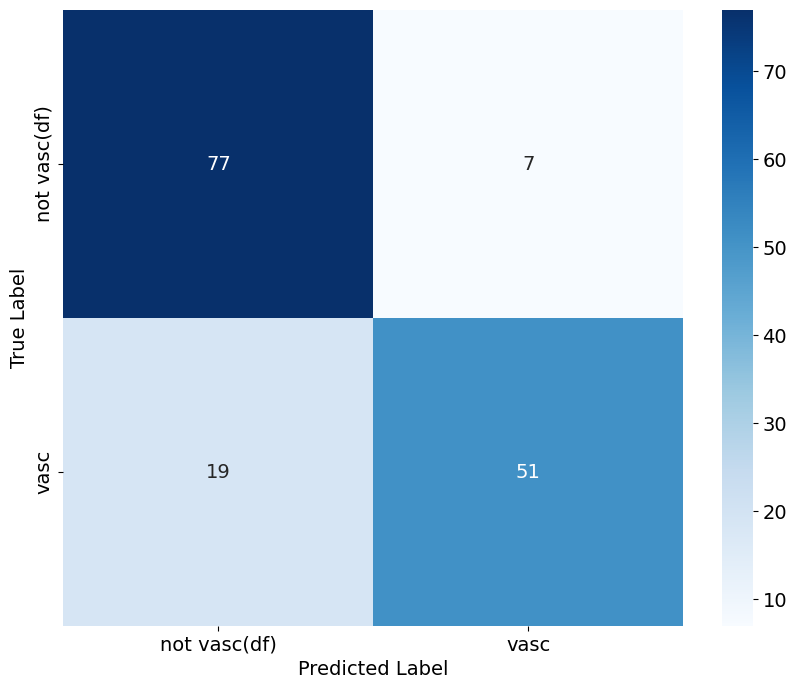

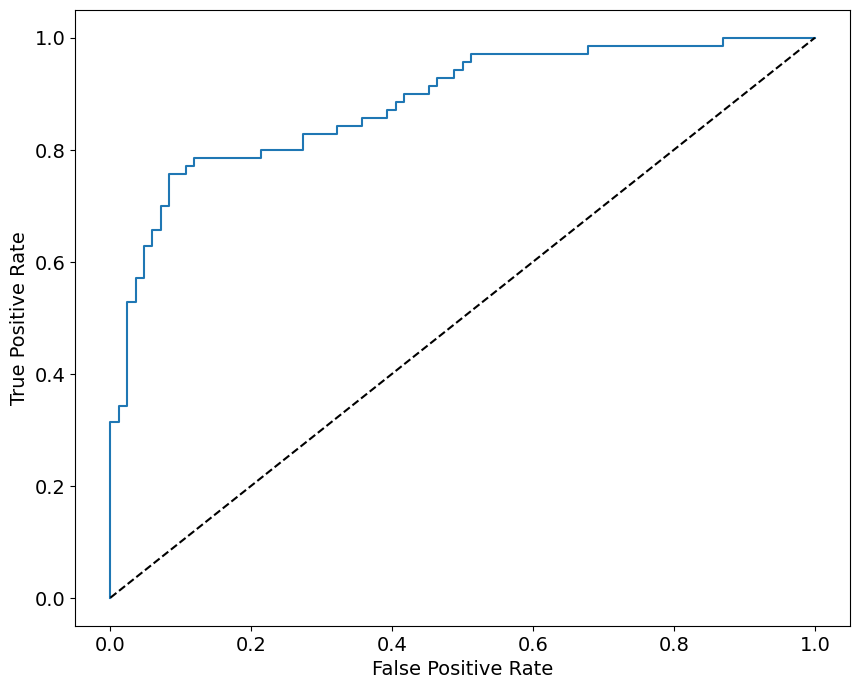

              precision    recall  f1-score   support

not vasc(df)       0.80      0.92      0.86        84
        vasc       0.88      0.73      0.80        70

    accuracy                           0.83       154
   macro avg       0.84      0.82      0.83       154
weighted avg       0.84      0.83      0.83       154



In [100]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report
import os

# Ensure output directory exists
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

# Reset test_generator_vasc to ensure it starts from the first sample
test_generator_vasc.reset()

# Get the number of samples and batch size
num_samples = test_generator_vasc.n  # Total number of samples (2013)
batch_size = test_generator_vasc.batch_size  # 128
steps = int(np.ceil(num_samples / batch_size))  # 16

# Debug: Print number of samples, batch size, steps, and class indices
print(f"Number of test samples: {num_samples}")
print(f"Batch size: {batch_size}")
print(f"Steps: {steps}")
print(f"Class indices: {test_generator_vasc.class_indices}")

# Predict probabilities using model2
predictions = model6.predict(test_generator_vasc, steps=steps)

# Debug: Print shape of predictions
print(f"Shape of predictions: {predictions.shape}")

# Handle model output
if predictions.shape[1] == 2:
    y_pred_prob = predictions[:, 1]  # Softmax: probability for positive class ("nv")
elif predictions.shape[1] == 1:
    y_pred_prob = predictions.ravel()  # Sigmoid output
else:
    raise ValueError(f"Unexpected model output shape: {predictions.shape}")

y_pred = (y_pred_prob > 0.5).astype(int)

# Get true labels from test_generator_vasc and convert to NumPy array
y_true = np.array(test_generator_vasc.classes, dtype=np.int64)

# Debug: Print unique values, types, and sample labels
print(f"Unique y_true values: {np.unique(y_true)}")
print(f"y_true type: {type(y_true[0])}")
print(f"Sample y_true (first 10): {y_true[:10]}")
print(f"Sample y_pred (first 10): {y_pred[:10]}")
print(f"Length of y_true: {len(y_true)}")
print(f"Length of y_pred: {len(y_pred)}")
print(f"y_pred type: {type(y_pred[0])}")

# Ensure y_true and y_pred have the same length and type
assert len(y_true) == len(y_pred), f"Mismatch between y_true ({len(y_true)}) and y_pred ({len(y_pred)}) lengths"
assert isinstance(y_true[0], type(y_pred[0])), f"Type mismatch: y_true ({type(y_true[0])}), y_pred ({type(y_pred[0])})"

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['not vasc(df)', 'vasc']

# Compute accuracy from confusion matrix
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"Accuracy from confusion matrix: {accuracy:.2%}")

# Plot and Save Confusion Matrix as Heatmap using Seaborn
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 14})
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# plt.title('Confusion Matrix Heatmap (Model1)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(os.path.join(output_dir, 'confusion_matrix_heatmap_model6.png'), dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# # Plot and Save Confusion Matrix using ConfusionMatrixDisplay
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
# disp.plot(cmap='Blues')
# plt.title('Confusion Matrix (Model1)')
# plt.savefig(os.path.join(output_dir, 'confusion_matrix_display_model2.png'), dpi=300, bbox_inches='tight')
# plt.show()
# plt.close()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 14})
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC Curve (Model1)')
# plt.legend(loc='lower right')
plt.savefig(os.path.join(output_dir, 'roc_curve_model6.png'), dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# Save Classification Report to a text file
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)
with open(os.path.join(output_dir, 'classification_report_model6.txt'), 'w') as f:
    f.write(report)

In [ ]:
# test_dataX = X[test_ind[test_cascade]]
# test_dataY = y[test_ind[test_cascade]]
# def binary_cascading_classification(test_dataX,classes_dict):
    
#     y_pred = []
#     for i in range(test_dataX.shape[0]):
#         x = np.expand_dims(test_dataX[i],axis=0)
#         if classes_dict['Nv'][np.argmax(model1.predict(x))] == 'nv':
#             y_pred.append('nv')
#         elif classes_dict['Mel'][np.argmax(model2.predict(x))]== 'mel':
#             y_pred.append('mel')
#         elif classes_dict['Bkl'][np.argmax(model3.predict(x))] == 'bkl':
#             y_pred.append('bkl')
#         elif classes_dict['Bcc'][np.argmax(model4.predict(x))] == 'bcc':
#             y_pred.append('bcc')
#         elif classes_dict['Akiec'][np.argmax(model5.predict(x))] == 'akiec':
#             y_pred.append('akiec')
#         elif classes_dict['Vasc'][np.argmax(model6.predict(x))] == 'vasc':
#             y_pred.append('vasc')
#         else:
#             y_pred.append('df')
#     return y_pred

In [ ]:
# y_pred=binary_cascading_classification(test_dataX,classes_dict)

In [ ]:
import numpy as np

def binary_cascading_classification(test_dataX, classes_dict, model1, model2, model3, model4, model5, model6):
    """
    Performs binary cascading classification using multiple models.

    Args:
        test_dataX (numpy.ndarray): Input test data.
        classes_dict (dict): Dictionary mapping model output indices to class labels.
        model1, model2, model3, model4, model5, model6 (keras.Model): Trained binary classification models.

    Returns:
        list: List of predicted class labels.
    """

    y_pred = []
    for i in range(test_dataX.shape[0]):
        x = np.expand_dims(test_dataX[i], axis=0)

        # Model 1: Nv vs. Rest
        if classes_dict['Nv'][np.argmax(model1.predict(x, verbose=0))] == 'nv':
            y_pred.append('nv')
        # Model 2: Mel vs. Rest
        elif classes_dict['Mel'][np.argmax(model2.predict(x, verbose=0))] == 'mel':
            y_pred.append('mel')
        # Model 3: Bkl vs. Rest
        elif classes_dict['Bkl'][np.argmax(model3.predict(x, verbose=0))] == 'bkl':
            y_pred.append('bkl')
        # Model 4: Bcc vs. Rest
        elif classes_dict['Bcc'][np.argmax(model4.predict(x, verbose=0))] == 'bcc':
            y_pred.append('bcc')
        # Model 5: Akiec vs. Rest
        elif classes_dict['Akiec'][np.argmax(model5.predict(x, verbose=0))] == 'akiec':
            y_pred.append('akiec')
        # Model 6: Vasc vs. Rest
        elif classes_dict['Vasc'][np.argmax(model6.predict(x, verbose=0))] == 'vasc':
            y_pred.append('vasc')
        else:
            y_pred.append('df')  # Default class if none of the above match

    return y_pred

In [ ]:
!pip install reportlab
from reportlab.pdfgen import canvas
from matplotlib.backends.backend_pdf import PdfPages
report = classification_report(test_dataY, y_pred, output_dict=True)
report_str = classification_report(test_dataY, y_pred)

# Save the report as a text in PDF
pdf_filename = 'classification_report.pdf'
c = canvas.Canvas(pdf_filename)
c.drawString(100, 750, report_str)
c.save()

# Alternatively, visualize the classification report as a plot
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.text(0.01, 0.5, report_str, {'fontsize': 12}, fontproperties = 'monospace')
pdf_pages = PdfPages('classification_report_plot.pdf')
pdf_pages.savefig(bbox_inches='tight')
pdf_pages.close()

print("Classification report saved as PDF.")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from reportlab.pdfgen import canvas
from matplotlib.backends.backend_pdf import PdfPages

test_dataX = X[test_ind[test_cascade]]
test_dataY = y[test_ind[test_cascade]]

# Define classes_dict (to match your model outputs)
classes_dict = {
    'Nv': {0: 'nv'},  # model1 outputs 0 for 'nv'
    'Mel': {0: 'mel'}, 
    'Bkl': {0: 'bkl'}, 
    'Bcc': {0: 'bcc'}, 
    'Akiec': {0: 'akiec'},
    'Vasc': {0: 'vasc'} 
}


def binary_cascading_classification(test_dataX, classes_dict):
    y_pred = []
    for i in range(test_dataX.shape[0]):
        x = np.expand_dims(test_dataX[i], axis=0)

        # Get probabilities from each model
        nv_prob = model1.predict(x)
        mel_prob = model2.predict(x)
        bkl_prob = model3.predict(x)
        bcc_prob = model4.predict(x)
        akiec_prob = model5.predict(x)
        vasc_prob = model6.predict(x)

        # Make predictions based on highest probability and classes_dict:
        if np.argmax(nv_prob) in classes_dict['Nv']: #Check if predicted index is a key in the dictionary
            y_pred.append(classes_dict['Nv'][np.argmax(nv_prob)])
        elif np.argmax(mel_prob) in classes_dict['Mel']:
            y_pred.append(classes_dict['Mel'][np.argmax(mel_prob)])
        elif np.argmax(bkl_prob) in classes_dict['Bkl']:
            y_pred.append(classes_dict['Bkl'][np.argmax(bkl_prob)])
        elif np.argmax(bcc_prob) in classes_dict['Bcc']:
            y_pred.append(classes_dict['Bcc'][np.argmax(bcc_prob)])
        elif np.argmax(akiec_prob) in classes_dict['Akiec']:
            y_pred.append(classes_dict['Akiec'][np.argmax(akiec_prob)])
        elif np.argmax(vasc_prob) in classes_dict['Vasc']:
            y_pred.append(classes_dict['Vasc'][np.argmax(vasc_prob)])
        else:
            y_pred.append('dfd')  # Default class

    return y_pred

y_pred = binary_cascading_classification(test_dataX, classes_dict)


# Convert test_dataY to a 1D array if it's not already
if len(test_dataY.shape) > 1:  # Check if it's not already 1D
    test_dataY = np.argmax(test_dataY, axis=-1) #If it's one-hot encoded, convert it to 1D array

# Ensure y_pred and test_dataY have the same data type
y_pred = np.array(y_pred)  # Convert to NumPy array
test_dataY = np.array(test_dataY)

#If labels are numerical, convert y_pred to numerical as well
# if isinstance(test_dataY[0], np.int64): #Check if test_dataY is numerical
#     from sklearn.preprocessing import LabelEncoder
#     le = LabelEncoder()
#     le.fit(y_pred)
#     y_pred=le.transform(y_pred)

print("Shape of y_pred:", y_pred.shape)
print("Shape of test_dataY:", test_dataY.shape)

report = classification_report(test_dataY, y_pred, output_dict=True)
report_str = classification_report(test_dataY, y_pred)

# ... (rest of your PDF saving code remains the same) ...

pdf_filename = 'classification_report.pdf'
c = canvas.Canvas(pdf_filename)
c.drawString(100, 750, report_str)
c.save()

plt.figure(figsize=(10, 6))
plt.axis('off')
plt.text(0.01, 0.5, report_str, {'fontsize': 12}, fontproperties='monospace')
pdf_pages = PdfPages('classification_report_plot.pdf')
pdf_pages.savefig(bbox_inches='tight')
pdf_pages.close()

print("Classification report saved as PDF.")

In [ ]:
y_prob=model4.predict(test_generator)
class_dict ={0:'not nv', 1:'nv'}
y_pred = []
for ele in y_prob:
    y_pred.append(class_dict[np.argmax(ele)])

In [ ]:
# y_true=metadata[metadata.index.isin(test_nv)]['is_nv']
import pandas as pd
import numpy as np
# ... other imports

# ... (your model definitions and test_dataX definition)

test_nv_indices = test_ind[test_cascade]
test_nv = metadata.index[test_nv_indices]
y_true = metadata.loc[test_nv, 'is_nv']  # More concise way to extract y_true

# ... (classes_dict definition and binary_cascading_classification function)

y_pred = binary_cascading_classification(test_dataX, classes_dict)

# Convert y_true and y_pred to numerical labels if needed
if isinstance(y_pred[0], str):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    le.fit(y_pred)
    y_pred = le.transform(y_pred)

if isinstance(y_true.iloc[0], str):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    le.fit(y_true)
    y_true = le.transform(y_true)


y_true = y_true.values if isinstance(y_true, pd.Series) else y_true  # Concise conversion
y_pred = np.array(y_pred) # Concise conversion


# ... (rest of the code for classification report and PDF saving)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

# Example data (replace with your actual data)
metadata = pd.DataFrame({'is_nv': [0, 1, 0, 1, 0]}, index=[10, 11, 12, 13, 14])
test_ind = np.array([0, 1, 2])  # Example indices
test_cascade = np.array([0, 1, 2]) #Example cascade indices
X = np.random.rand(15, 100, 100, 3) # Example image data

test_dataX = X[test_ind[test_cascade]]
test_nv_indices = test_ind[test_cascade]
test_nv = metadata.index[test_nv_indices]
y_true = metadata.loc[test_nv, 'is_nv']

# Dummy y_pred (replace with your actual predictions) - MAKE SURE IT HAS THE CORRECT LENGTH
y_pred = np.array([0, 1, 0])  # Correct length!

print("Shape of y_true:", y_true.shape)
print("Shape of y_pred:", y_pred.shape)

print(classification_report(y_true, y_pred))

In [ ]:
print(test_generator.class_indices)

In [ ]:
classes_dict={}

In [ ]:
classes_dict['Nv']=test_generator.class_indices
classes_dict['Mel']=test_generator_mel.class_indices
classes_dict['Bkl']=test_generator_bkl.class_indices
classes_dict['Bcc']=test_generator_bcc.class_indices
classes_dict['Akiec']=test_generator_akiec.class_indices
classes_dict['Vasc']=test_generator_vasc.class_indices

In [ ]:
print(classes_dict)

In [ ]:
classes_dict['Nv'] = {value:key for key,value in test_generator.class_indices.items()}
classes_dict['Mel'] = {value:key for key,value in test_generator_mel.class_indices.items()}
classes_dict['Bkl'] = {value:key for key,value in test_generator_bkl.class_indices.items()}
classes_dict['Bcc'] = {value:key for key,value in test_generator_bcc.class_indices.items()}
classes_dict['Akiec'] = {value:key for key,value in test_generator_akiec.class_indices.items()}
classes_dict['Vasc'] = {value:key for key,value in test_generator_vasc.class_indices.items()}